In [1]:
#!pip install  nbconvert[webpdf]
import nbconvert

In [2]:
#!pip install --upgrade yfinance


In [3]:
#!pip install --upgrade certifi requests urllib3


In [4]:
import requests

url = "https://stooq.com/q/d/l/?s=eurusd&i=d"
response = requests.get(url)
print(response.status_code)
print(response.text[:200])


200
Date,Open,High,Low,Close
1971-01-04,0.5353,0.5353,0.5353,0.5353
1971-01-05,0.535,0.535,0.535,0.535
1971-01-06,0.5352,0.5352,0.5352,0.5352
1971-01-07,0.5353,0.5353,0.5353,0.5353
1971-01-08,0.5354,


In [5]:
import pandas as pd
import requests
from io import StringIO

# URL for EUR/USD daily OHLC from Stooq
url = "https://stooq.com/q/d/l/?s=eurusd&i=d"

# Download CSV text
csv_text = requests.get(url).text

# Load into DataFrame
df = pd.read_csv(StringIO(csv_text))

# Sort oldest → newest
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

# Filter your required date range
start = "2000-01-01"
end = "2025-11-15"
df = df[(df["Date"] >= start) & (df["Date"] <= end)]

print(df.head())
print(df.tail())
print(df.shape)


           Date    Open    High     Low   Close
7339 2000-01-03  1.0050  1.0280  1.0048  1.0262
7340 2000-01-04  1.0240  1.0343  1.0210  1.0308
7341 2000-01-05  1.0293  1.0402  1.0280  1.0314
7342 2000-01-06  1.0320  1.0414  1.0270  1.0319
7343 2000-01-07  1.0324  1.0330  1.0250  1.0289
            Date     Open     High      Low    Close
14042 2025-11-10  1.15587  1.15832  1.15414  1.15572
14043 2025-11-11  1.15579  1.16060  1.15477  1.15855
14044 2025-11-12  1.15848  1.15980  1.15633  1.15904
14045 2025-11-13  1.15912  1.16556  1.15793  1.16365
14046 2025-11-14  1.16368  1.16533  1.16066  1.16209
(6708, 5)


- **Introduction: Exploring Exchange Rate Volatility with Machine Learning**

- In this notebook I will explore the calculation of volatility using both traditional and Machine Learning methods, including:
  - Simulated Annealing  
  - Particle Swarm Optimization  
  - Genetic Algorithm  
  - Adaptations of Quasi-Newton methods  

- We will also use traditional measures of conditional volatility from:
  - GARCH estimation (GCV), and  
  - The Bollerslev et al "OK" method of calculated Range Volatility (RV).  
  These will be compared with volatility from estimated Stochastic Volatility Jump Diffusion (SVJD) models.

- The basic point is that the traditional GARCH model does not give much information about the underlying latent volatility process. There are shocks to uncertainty as well as infrequent jumps in the data. By ignoring these additional stochastic processes in the data-generating process, the GARCH specification is much less informative than these more complex methods.

- This paper examines the Euro/Dollar exchange rate using daily data spanning twenty years.

- We first:
  - Compare the exchange rate itself  
  - Then examine log first differences  
  - Then calculate Range Volatility using daily open, close, high, and low data  
  - Finally examine GARCH outcomes  
  The point of all this is that there is more to the story than standard GARCH captures.

- I then examine the Stochastic Volatility Jump Diffusion (SVJD) model introduced by Bates (1996):  
  *David S. Bates, “Jumps and Stochastic Volatility: Exchange Rate Processes Implicit in Deutsche Mark Options,” The Review of Financial Studies, 9(1), 1996, pp. 69–107.*  
  This model has been widely used for option pricing.

- Our first purpose is simply to extract the underlying latent volatility process.

- We then discuss options for estimating the parameters of this model, including:
  - Log-likelihood maximization  
  - Generalized Method of Moments (GMM)

- Since these estimation processes involve considerable complexity, we discuss both global search methods and local gradient-based methods for obtaining the results.


$\textbf{Importing the Data from STOOQ}$

## 📊 Data Source: **Stooq**

For this project, the exchange rate data are obtained from **[Stooq](https://stooq.com/)** — a free, publicly accessible financial data platform widely used in academic and professional research.

### 🔹 What is Stooq?
Stooq is a financial market database that provides **historical and real-time data** for:
- Foreign exchange rates (FX)
- Equity indices
- Individual stocks
- Commodities
- Bonds
- Macroeconomic indicators

The platform is maintained by financial data specialists and is frequently cited in empirical finance research due to its **broad coverage and open access**.

### 🔹 Why Use Stooq?
- ✔️ **Free & No API Key Required**  
- ✔️ **Reliable long-span historical data**  
- ✔️ **CSV downloads available directly from the website**  
- ✔️ **Daily, weekly, and intraday frequencies**

### 🔹 Example: EUR/USD Exchange Rate
The EUR/USD daily series can be downloaded using a direct CSV link such as:


Where:
- `s=` specifies the symbol (`eurusd`)
- `c=all` requests the full available history

### 🔹 Typical Data Fields Include:
- `Date`
- `Open`
- `High`
- `Low`
- `Close`
- `Volume` (when applicable)

These fields allow calculation of:
- Log-returns  
- Range-based volatility  
- Conditional and stochastic volatility measures  

---

Stooq’s accessibility and depth make it particularly useful for **exchange-rate volatility research, teaching, and reproducible financial analytics.**






   index       Date    Open    High     Low   Close
0   7339 2000-01-03  1.0050  1.0280  1.0048  1.0262
1   7340 2000-01-04  1.0240  1.0343  1.0210  1.0308
2   7341 2000-01-05  1.0293  1.0402  1.0280  1.0314
3   7342 2000-01-06  1.0320  1.0414  1.0270  1.0319
4   7343 2000-01-07  1.0324  1.0330  1.0250  1.0289


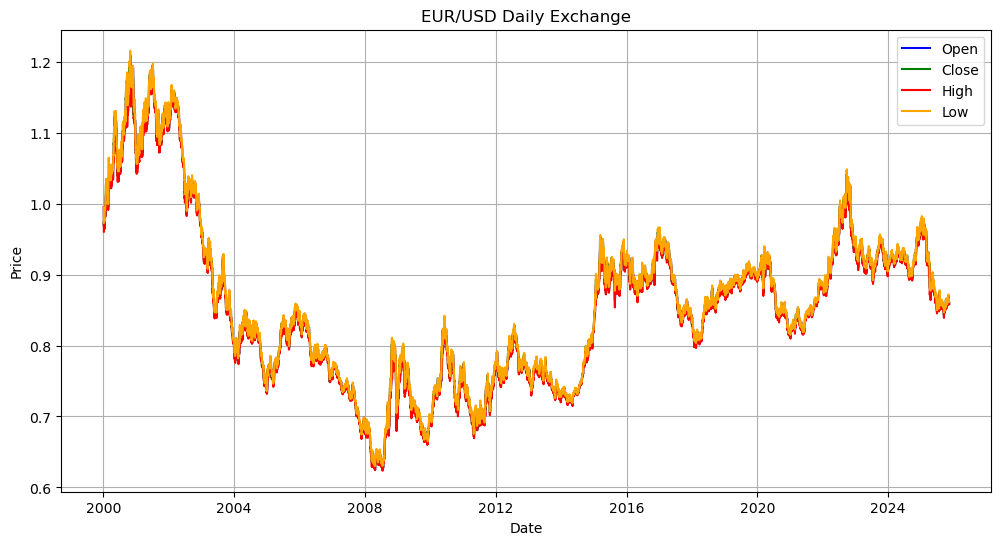

In [6]:

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


# Define the currency pair symbol (CNY/USD) and date range
# currency_pair = "CNYUSD=X"  # Yahoo Finance symbol for CNY/USD
#currency_pair = "EURUSD=X"
#start_date = "2008-12-01"
#end_date = "2025-11-05"

# Fetch historical data
#ch_data = yf.download(currency_pair, start=start_date, end=end_date, progress=False)
df
# Reset the index to access date as a column
df.reset_index(inplace=True)

# Access the 'Date' column
date = df['Date']

# Print the first few rows of the 'Date' column
print(df.head())

open_price = 1/df['Open']
high_price = 1/df['High']
low_price = 1/df['Low']
close_price = 1/df['Close']

high = high_price
low = low_price
close = close_price
open = open_price




# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(date, open, label='Open', color='blue')
plt.plot(date, close, label='Close', color='green')
plt.plot(date, high, label='High', color='red')
plt.plot(date, low, label='Low', color='orange')
plt.title('EUR/USD Daily Exchange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


We now calculate the log-first differences of the series.  Note that we have to start the date vector one period later since we lost an observation.

In [7]:
import numpy as np
close_price = np.array(close)
close_price
#eurus_diff = np.diff(np.log(close_price))
eurus_diff =   np.diff(np.log(close_price))
#close_price = close_price.interpolate(method='linear')
#eurus_diff1 = close_price.pct_change().dropna()
#close_price1 = close_price.iloc[:,1]
eurus_diff2 = np.log(close_price[1:]/close_price[:-1])
eurus_diff2


array([-0.00447254, -0.0005819 , -0.00048466, ..., -0.00042285,
       -0.00396954,  0.00134151])

Text(0.5, 1.0, 'Daily Rate of Change of Dollar/Euro Closing Price')

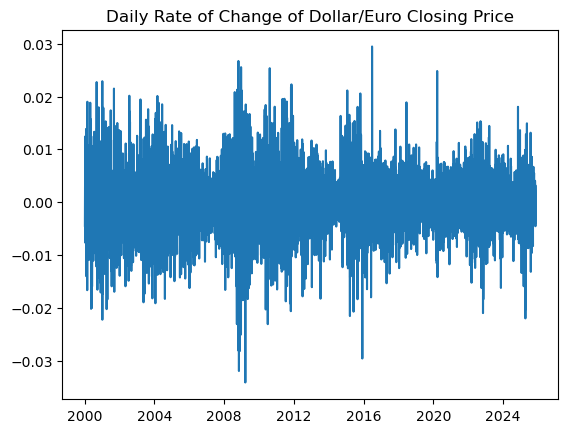

In [8]:
plt.plot(date[1:], eurus_diff2)
plt.title('Daily Rate of Change of Dollar/Euro Closing Price')

$\textbf{Squared First-Differences}$

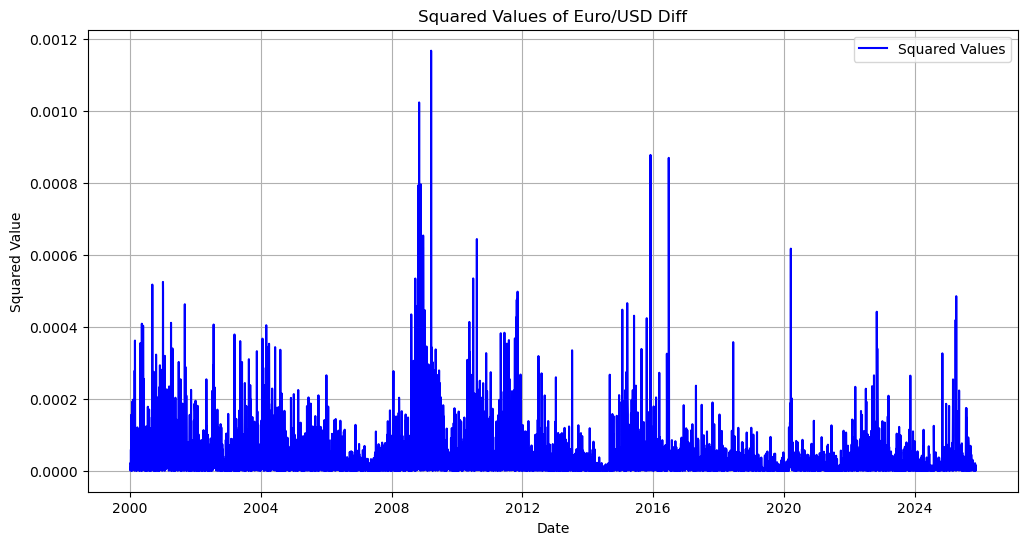

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming eurus_diff2 is a NumPy array or list of values
eurus_diff2 = np.array(eurus_diff2)  # Convert to a NumPy array if not already

# Square each element of the vector
eurus_diff_sq = np.square(eurus_diff2)

# Assuming date[1:] corresponds to the dates for the entire dataset
dates = date[1:]

# Plot the squared values
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(dates, eurus_diff_sq, label='Squared Values', color='blue')

# Customize the plot as needed (e.g., labels, title, legend, etc.)
plt.xlabel('Date')
plt.ylabel('Squared Value')
plt.title('Squared Values of Euro/USD Diff')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


$\textbf{Rolling Standard Deviations}$

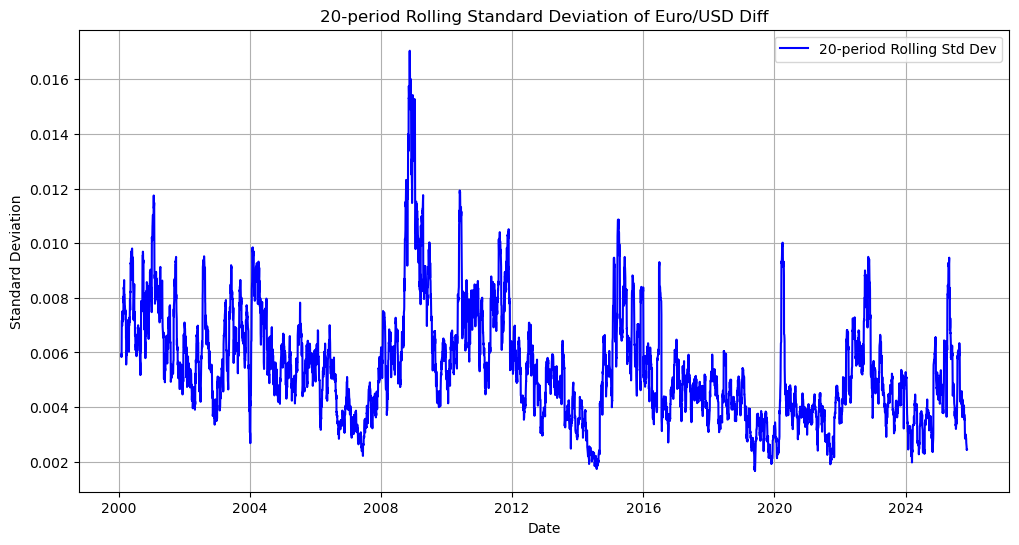

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'date' is a list or array of dates and 'eurousdiff' is the corresponding series
# Convert them to a Pandas DataFrame
df = pd.DataFrame({'Date': date[1:], 'Euro': eurus_diff2})

# Calculate the 20-period rolling standard deviation for the 'Euro' column
rolling_std = df['Euro'].rolling(window=20).std()

# Plot the rolling standard deviation
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(df['Date'], rolling_std, label='20-period Rolling Std Dev', color='blue')

# Customize the plot as needed (e.g., labels, title, legend, etc.)
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.title('20-period Rolling Standard Deviation of Euro/USD Diff')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


$\textbf{Jumps}$

In [11]:
import numpy as np

def count_jumps_and_average_jump_size(data, threshold):
    num_jumps = 0
    total_jump_size = 0  # To calculate the total jump size

    for i in range(1, len(data)):
        jump_size = abs(data[i] - data[i - 1])
        if jump_size > threshold:
            num_jumps += 1
            total_jump_size += jump_size

    if num_jumps > 0:
        average_jump_size = total_jump_size / num_jumps
    else:
        average_jump_size = 0  # To handle the case with no jumps

    pnum_jumps = num_jumps/len(data)

    return pnum_jumps, average_jump_size

# Example usage:


In [12]:
data = np.diff(np.log(close_price))

threshold = 2.576 * np.std(data)
pnum_jumps, average_jump_size = count_jumps_and_average_jump_size(data, threshold)

print("% Percentage of number of jumps:", pnum_jumps)
print("Average jump size:", average_jump_size)
print('threshold',threshold)



% Percentage of number of jumps: 0.06992694200089458
Average jump size: 0.020091797318473253
threshold 0.015055628615404569


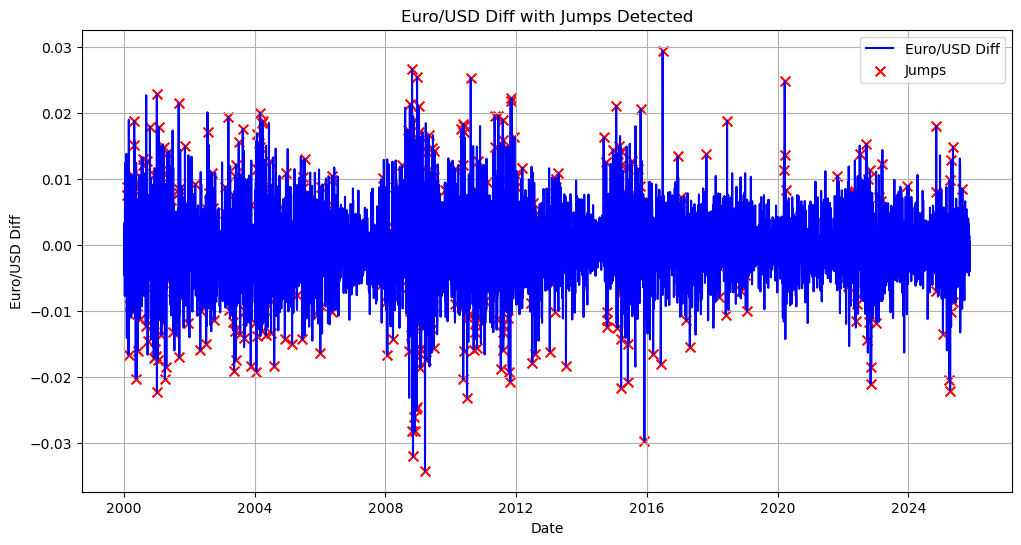

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'date' is a list or array of dates and 'eurousdiff' is the corresponding series
# Convert them to a Pandas DataFrame
df = pd.DataFrame({'Date': date[1:], 'Euro': eurus_diff2})

# Set a threshold for identifying jumps (you can adjust this threshold)

# Calculate the absolute differences between consecutive data points
absolute_changes = df['Euro'].diff().abs()

# Identify jumps by comparing with the threshold
jumps = absolute_changes > threshold

# Plot the 'Euro' series
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(df['Date'], df['Euro'], label='Euro/USD Diff', color='blue')

# Plot jumps as red markers
plt.scatter(df['Date'][jumps], df['Euro'][jumps], c='red', label='Jumps', marker='x', s=50)

# Customize the plot as needed (e.g., labels, title, legend, etc.)
plt.xlabel('Date')
plt.ylabel('Euro/USD Diff')
plt.title('Euro/USD Diff with Jumps Detected')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


$\textbf{Bollerslev at al OK Range Volatility Measure}$

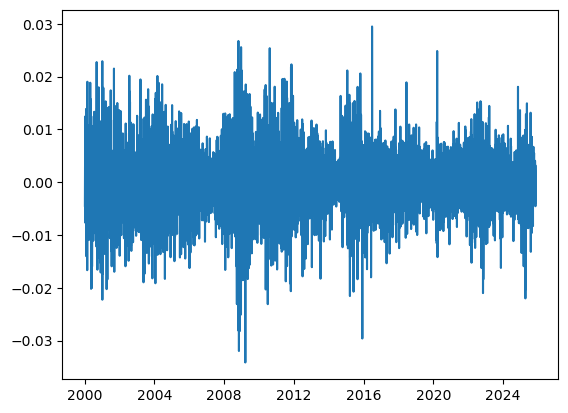

In [14]:
plt.plot(date[1:],eurus_diff2)

In [15]:
import numpy as np
#rangevol1 =  .5*(np.log(high)-np.log(low))**2 - (2*np.log(2)-1)*(np.log(close)-np.log(open))**2;
rangevol1 = 0.811 * np.abs(np.log(high) - np.log(low)) - 0.369 * np.abs(np.log(close) - np.log(open))

window_size = 20

# Calculate the rolling window average
rangevol = np.convolve(rangevol1, np.ones(window_size) / window_size, mode='valid')
rangevol = rangevol/rangevol[0]

# Print the rolling average
print(len(rangevol))
print(len(date[window_size-1:]))

6689
6689


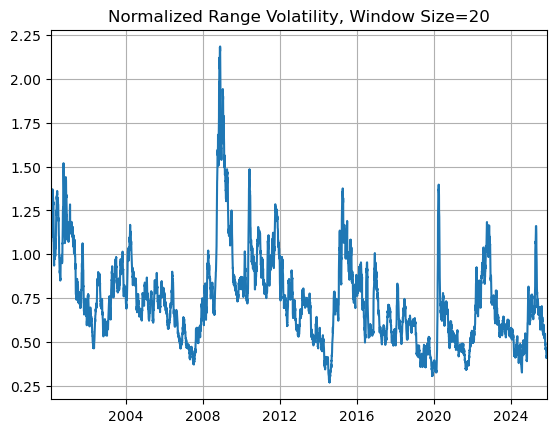

In [16]:
plt.plot(date[window_size-1:], rangevol)
plt.title('Normalized Range Volatility, Window Size=20')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

### **EGARCH Estimation with an AR Term**

- **Goal of this section**
  - We estimate an **EGARCH model** in which:
    - The **mean equation** includes an **autoregressive (AR) term**
    - The **variance equation** follows an **Exponential-GARCH (EGARCH)** specification

---

### **What is EGARCH?**

- **EGARCH = Exponential Generalized Autoregressive Conditional Heteroskedasticity**
- **Proposed by:** Nelson (1991)
- **Key motivations**
  - Standard GARCH struggles to capture **asymmetry** in financial returns  
  - EGARCH allows **negative shocks (bad news)** to have **larger volatility effects** than positive shocks of the same size  
    - This is known as the **leverage effect**
- **Main features**
  - Models the **log of the variance**, ensuring variance is always positive  
  - Captures:
    - Volatility clustering  
    - Persistence in volatility  
    - Asymmetric responses to shocks  

---

### **AR Term in the Mean Equation**

- We specify the **conditional mean of returns** as:
  - A function of **its own lag(s)**  
  - This allows returns to display **serial correlation**
- Example intuition:
  - If yesterday’s return was positive, today’s expected return may also be slightly positive

---

### **Limitations of EGARCH**

- Volatility depends on **prediction errors from the mean equation**
- There are **no separate independent shocks to volatility**
  - i.e., volatility is entirely **error-driven**
- This means:
  - The latent volatility process is **not treated as an independent state variable**
  - Making it less flexible than **true stochastic-volatility models**

---

### **Other ARCH/GARCH Models in the `arch` Python Library**

You can choose different models using the `vol=` argument in `arch_model()`:

- **`"Garch"`**
  - Standard GARCH model  
  - Variance depends on:
    - Lagged squared returns  
    - Lagged conditional variance  

- **`"EGarch"`**
  - Exponential GARCH  
  - Captures **asymmetric volatility responses**

- **`"GJR"`**
  - Also called GJR-GARCH  
  - Variance reacts differently to **negative vs positive shocks**

- **`"Constant"`**
  - Assumes **constant variance over time**

- **`"Harch"`**
  - Heterogeneous ARCH  
  - Allows multiple time-scale volatility components

- **`"RiskMetrics"`**
  - Uses **exponentially weighted moving averages (EWMA)**  
  - Popular in risk management (Value-at-Risk)

- **Rolling / Smoothing-style models**
  - `"Expanding"` – expanding-window volatility
  - `"FixedSmoothing"` – fixed smoothing volatility estimate
  - `"GarchRolling"` – rolling-window GARCH estimation

- **Custom order GARCH**
  - `"Garchpq"` – lets you specify your own `p` and `q` orders

- **Threshold GARCH**
  - `"Tarch"` – allows structural breaks in volatility once a shock exceeds a threshold

---

### **Summary**

- EGARCH models:
  - Handle **asymmetric volatility reactions**
  - Allow for **persistent and clustered variance**
  - Model **log-variance** to guarantee positivity
- BUT:
  - Volatility only evolves through **return shocks**
  - There is **no independent volatility shock process**

This makes EGARCH a powerful—but still limited—tool compared with **stochastic-volatility and jump-diffusion models**, which explicitly model volatility as its own latent state process.






In [17]:
#!pip install arch
import arch

import numpy as np
import pandas as pd
import arch






y = 100* eurus_diff
model = arch.arch_model(y, vol='EGarch', p=1, q=1, dist='StudentsT', mean='ARX', lags=1)

# Fit the GARCH model
results = model.fit(options={'maxiter': 5000})
# Print the model summary
print(results.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 332348.112295402
Iteration:      2,   Func. Count:     20,   Neg. LLF: 87450.76550754499
Iteration:      3,   Func. Count:     31,   Neg. LLF: 40655.81520627778
Iteration:      4,   Func. Count:     43,   Neg. LLF: 430174.2075488274
Iteration:      5,   Func. Count:     54,   Neg. LLF: 5320.614533001814
Iteration:      6,   Func. Count:     61,   Neg. LLF: 11861.433379860844
Iteration:      7,   Func. Count:     69,   Neg. LLF: 43825.94400994375
Iteration:      8,   Func. Count:     79,   Neg. LLF: 5313.9901747738295
Iteration:      9,   Func. Count:     86,   Neg. LLF: 5314.166461816899
Iteration:     10,   Func. Count:     94,   Neg. LLF: 5313.896697952165
Iteration:     11,   Func. Count:    101,   Neg. LLF: 5313.895609735635
Iteration:     12,   Func. Count:    108,   Neg. LLF: 5313.895491923264
Iteration:     13,   Func. Count:    115,   Neg. LLF: 5313.895489989411
Iteration:     14,   Func. Count:    121,   Neg. LLF: 5313.8954

6706
6687


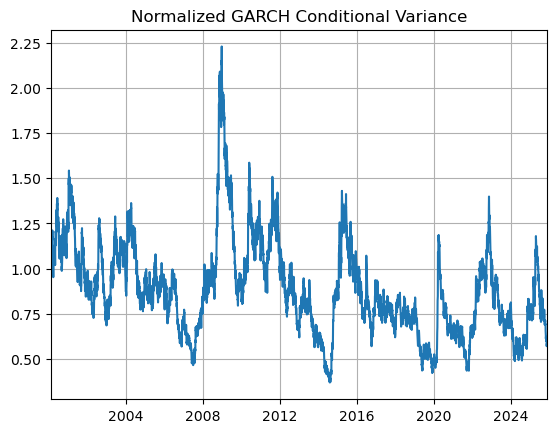

In [18]:
ConVar = results.conditional_volatility

window_size = 20

# Calculate the rolling window averag
ConVar = ConVar[1:]
ConVar1 = np.convolve(ConVar, np.ones(window_size) / window_size, mode='valid')


ConVar1 = ConVar/ConVar[0]
# Print the rolling average
print(len(ConVar1))

date2 = date[2:]
print(len(date2[window_size-1:]))
plt.plot(date2[window_size-1:], ConVar1[window_size-1:])
plt.title("Normalized GARCH Conditional Variance")
plt.grid(True)
plt.autoscale(axis='x', tight=True)

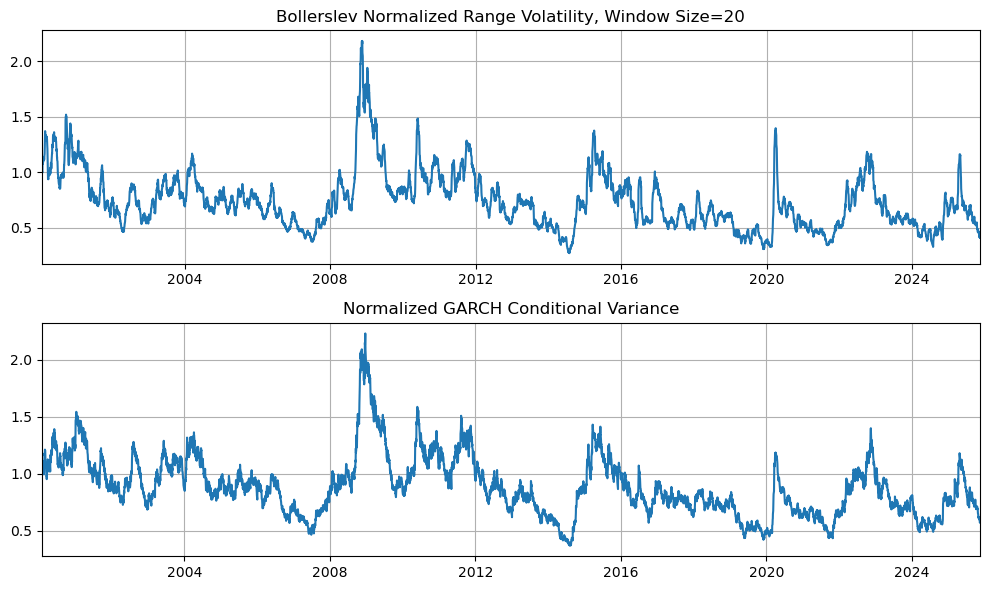

In [45]:

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot the first graph in the top subplot
axs[0].plot(date[window_size-1:], rangevol)
axs[0].set_title('Bollerslev Normalized Range Volatility, Window Size=20')
axs[0].grid(True)
axs[0].autoscale(axis='x', tight=True)

# Plot the second graph in the bottom subplot
date2 = date[2:]
axs[1].plot(date2[window_size-1:], ConVar1[window_size-1:])
axs[1].set_title("Normalized GARCH Conditional Variance")
axs[1].grid(True)
axs[1].autoscale(axis='x', tight=True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

We see that the conditional volatility is less volatile that the Range Volatility measure shows a lot less action than the GK measure following the GFC period in 2008 and 2009.

$\textbf{The Bates Stochastic Volatility Jump Diffusion Model}$


This model has the following continuous time representation:

$dW_{1,t} \sim \mathcal{N}(0,dt)$

$dN_t \sim \mathcal{P}(\lambda)$

$J_t \sim  \mathcal{N}(\mu_J, \sigma_J^2)$

$dS_t = rS_tdt + \sqrt{V_t}dW_{1,t}+ J_tdN_t$

$dW_{2,t} = \rho dW_{1,t} +\sqrt{1-\rho^2}\mathcal{N}(0,dt)$

$dV_t = \kappa (\theta-V_t)dt + \sigma\sqrt{V_t}dW_{2,t}$

$ Corr(dW_{1,t},dW_{2,t})  = \rho $

with the following terms:

dt:  unit of time, for daily data, dt= 1/252

$dW_{1,t}, dW_{2,t}$:  Normally distributed shocks to the mean return and volatility

$\mathcal{P}(\lambda)$:  Poisson shock with intensity $\lambda$

$J_t$:   Jump size, normally distributed with mean $\mu_t$ and variance $\sigma_J$

r:  risk free rate

$dS_t$; rate of return

$dV_t$ rate of change of the stochastic volatility, with restriction $V_t \ge 0$.

$\kappa$: mean-reversion coefficient of the stochastic volatility

$\theta$:  long-term stochastic volatility

$\sigma$: standard deviation of the process for stochastic volatility

$\rho$: correlation of the shocks to stochastic volatility and to returns, with the restriction:  $-1<\rho<1$

$V_0$: initial value for stochastic volatility, set equal to $\theta$

Our goal is to go behond the conditional variance of the GARCH, which only depends on the mean prediction errors, to a progress which has correlated shocks to the underlying mean and volatility processes.  From our observations on the daily rate of return, we thus wish to estimate five parameters.

The advantage of continuous time notation is that it is easy to shift estimation from daily to weekly or monthly data by changing the values of dt.




$\textbf{Issues for Empirical Implementation}$

- Issue: we need to select how we minimize a function
- But what is our accuracy measure?  
- This is our first choice or hyperparameter decision: how to we optimize a function
- What function, a likelihood function or Generalized Method of Moments estimation?
- Pros and cons of each.
- We have several choices: global vs. local methods, gradient vs stochastic search methods
- We also have to come to terms with non-convex error functions, there may be several local minima or saddle points
- The search for better optimization methods for nonlinear functions predates Machine Learning
- But Machine Learning or Computational Learning has contributed to this research agenda.



$\textbf{Estimation Objective}$


With various methods, we can have the objective of maximizing the Maximum Likelihood (ML) or, with the Generalized Method of Moments (GMM), minimizing the squared difference between key moments of the actual and simulated data of the model.

Maximum likelihood imposes the restriction of nomrally distributed shocks to the model. The ML method simply calculates the differences between the actual and predicted returns as well as the variance:

$\hat{\epsilon}_t = dS_t- \hat{dS}_t$

$\hat{\sigma}^2 = \frac{\sum_{t=1}^{N} \hat{\epsilon}_t^2}{N - k}$

and maximizes the log-likelihood function:

$\ln(\mathcal{L}) =  -N .5 \pi \sigma - .5 \Sigma (\frac{\hat{\epsilon}_t}{\sigma})^2$

where N is the number of observations and k is the number of parameters to be estimated. In our case, k=5.

The other method is the Generalized Method of Moments.  We simply calculate many moments of the actual and simulated data,
such as the first through fourth moments, for the mean, variance, skewness, and kurtosis.  We also calculate the autocorrelations of both actual data and simulated data, as well as the same autocorrelations of the squared values of the acutal and simulated data.  We also calculate the number of jumps and average size of the jumps in the actual and simulated data sets as additional moments. We them calculate the sum of squared differences beteen the moments of the actual and simulated data.











$\textbf{Local Gradient-Based Search:  The Quasi-Newton Method and Backpropagation}$

To minimize any non-linear function, we usually begin by ”initializing”  the parameter vector $\Omega$ at any initial value, $\Omega_{0}$,perhaps at randomly chosen values. We then ”iterate” on the coefficient set $\Omega$ until an error metric $ \Psi$ is minimized, by making use of first and second-order derivatives of the ”error metric” $\Psi$  with respect to the parameters.  This type of search, called a ”gradient-based search”, is for the optimum ”in the neighborhood” of the initial parameter vector, $\Omega_{0}$  For this reason, this type of search is a ”local” search.

The usual way in which one goes about doing this iteration is through the quasi-Newton algorithm. Starting with the initial set of sum of squared errors, $\Psi(\Omega_{0})$, based on the initial coefficient vector $\Omega_{0}$, a second-order Taylor expansion is used to find $\Psi(\Omega_{1}):\Psi(\Omega_{1})=\Psi(\Omega_{0})+\nabla_{0}(\Omega_{1}-\Omega_{0})+.5(\Omega_{1}-\Omega_{0})^{\prime}H_{0}(\Omega_{1}-\Omega_{0})$

where $\nabla_{0}$ is the gradient of the error function with respect to the parameter set $\Omega_{0}$ and $H_{0\text{ }}$ is the Hessian of the error function.

Letting $\Omega_{0}=[\Omega_{0,1},...\Omega_{0,k}]$, be the initial set of k parameters used in the network, the gradient vector $\nabla_{0}$ is defined as follows:

$\nabla_{0}=\left(\begin{array}{c}
\frac{\Psi(\Omega_{0,1}+h_{1},...\Omega_{0,k})-\Psi(\Omega_{0,1},...\Omega_{0,k})}{h_{1}}\\
\frac{\Psi(\Omega_{0,1}...\Omega_{0,i}+h_{i}...,\Omega_{0,k})-\Psi(\Omega_{0,1},...\Omega_{0,k})}{h_{i}}\\
.\\
.\\
\frac{\Psi(\Omega_{0,1},...\Omega_{0,i}..\Omega_{0,k}+h_{k})-\Psi(\Omega_{0,1},...\Omega_{0,k})}{h_{k}}
\end{array}\right)$

The denominator $h_{i}$  is usually set at max($\epsilon$,$\epsilon$$\Omega_{0,i})$,with $\epsilon=10^{-6}$.

The Hessian $H_{0}$ is the matrix of second-order partial derivatives of $\Psi$ with respect to the elements of $\Omega_{0}$, and are computed in a similar matter as the Jacobian or gradient vector.  The cross-partials or off-diagonal elements of the matrix $H_{0\text{ }}$ are given by the formula:

$\frac{\partial^{2}\Psi}{\partial\Omega_{0,i}\partial\Omega_{0,j}}=\frac{1}{h_{j}h_{i}}\left[\begin{array}{c}
\{\Psi(\Omega_{0,1},...,\Omega_{0,i}+h_{i},\Omega_{0,j}+h_{j},...\Omega_{0,k})-\Psi(\Omega_{0,1}...\Omega_{0,i,...}\Omega_{0,_{j}}+h_{j}...\Omega_{0,k})\}\\
-\{\Psi(\Omega_{0,1},...,\Omega_{0,i}+h_{i},\Omega_{0,j},...\Omega_{0,k})-\Psi(\Omega_{0,1},...\Omega_{0,k})\}
\end{array}\right]$

The direct second-order partials or diagonal elements are given by:

$\frac{\partial^{2}\Psi}{\partial\Omega_{0,i}^{2}}=\frac{1}{h_{i}^{2}}\left(\begin{array}{c}
\Psi(\Omega_{0,1},...,\Omega_{0,i}+h_{i},...\Omega_{0,k})-2\Psi(\Omega_{0,1},...\Omega_{0,k})\\
+\Psi(\Omega_{0,1},...,\Omega_{0,i}-h_{i},...\Omega_{0,k})
\end{array}\right)$

$\textbf{Implementations of Quasi-Newton Gradient Methods}$

Implementing the Quasi-Newton methods has been the challenge of computational methods.  The reason is that inverting the Hession method is, as the Brazilians would say, "um bicho de sept cabesas", or "a best with seven heads".  But there is also the vanishing gradient problem.  

- The error fuction from estimation is a function of the parameters we are trying to obtain, as well as the data set:
- The estimation problem becomes a function estimation problem
- $\Phi = f(\Omega;x,y)$
- Unlike Ordinary Least Squares, this function does not have a closed-form solution
- We have to iterate to find the optimal $\Omega^*$ starting with an initial guess, $\Omega_0$
- We use a second-order Taylor expansion:  
- $\Phi(\Omega_1) = \Phi(\Omega_0) + f'(\Omega_0)(\Omega_1 - \Omega_0)+ \frac{1}{2} (\Omega_1 - \Omega_0)' f''(\Omega_0) (\Omega_1 - \Omega_0)$
- Optimization yields the following:  $\Omega_1 = \Omega_0 - \frac{f'(\Omega_0)}{f''(\Omega_0)}$



- If $\Omega$ is a large vector of coefficients, the second derivative or Hessian may be hard, if not impossible, to invert
- So much of the work has been to find ways to approximate the inverse of the Hessian matrix
- Earlier work has been the BFGS method, but the popular one now is called ADAM.
- I will go over these methods in the Jupyther notebook.  They are options we can call with different tools


$\textbf{Stochastic and Grid Search Methods}$

- Some methods are quite simple.  One is Hill Climbing.
- Take initial guesses of the vector $\Omega_0$ as well as lower and upper bounds.
- Define a new vector $\Omega_1 = \Omega_{LB} + Z_k [\Omega_{UB}-\Omega_{LB}]$, where $Z_k$ is a k by 1 random vector
- Accept the new $\Omega_1$ is better than the initial guess, in terms of lower Error metric.
- Contine for many interations
- Another is the Nelder-Mead Simplex Method. It starts with an initial guess and upper and lower bounds.  So there are three vectors.  Rank them from worst to best, $\Omega_i$, i=1,2,3
- The method ranks the three vectors and takes an average of two best, $\Omega_c$
- Then we find $\Omega_r = \Omega_c + \alpha[\Omega_c-\Omega_1]$.  If $\Omega_r$ is best, expand simplex in this direction


$\textbf{All About Adam}$

- Adam stands for Adaptive Moments.

- Adam adapts the learning rate for each parameter during training. It maintains a separate learning rate for each parameter and updates them individually. This adaptiveness helps in converging faster and handling different scales of gradients.

- Exponential Moving Averages:
    1. Adam maintains two exponentially moving average vectors:

    2. First Moment (Mean): This is similar to a moving average of gradients and helps in estimating the mean of the gradient.
    3. Second Moment (Uncentered Variance): This is similar to a moving average of squared gradients and helps in estimating the uncentered variance of the gradient.
    4. Initialization: Adam initializes the first and second moments to zero vectors.

- Hyperparameters
    1. Adam has hyperparameters that control its behavior
    2. There is the learning rate (alpha), decay rates for the moving averages (beta1 for the first moment and beta2 for the second moment), and a small epsilon value (epsilon) added to prevent division by zero.

- Updating Parameters:

    1. For each parameter in the model, Adam calculates its gradient with respect to the loss.
    2. It updates the first moment estimate by taking a weighted average of the current gradient and the previous first moment estimate.
    3. It updates the second moment estimate in a similar manner.
    4. Adam then computes bias-corrected estimates of the first and second moments to account for their initialization at zero.
    5. Finally, it updates the model parameters using these bias-corrected estimates and the learning rate.

$\textbf{Global Methods: SA,GA, and PS}$

- More elaborate methods are Simulated Annealing (SA), the Genetic Algorithm (GA) and Particle Swarm {PS}
- The idea is that we start with randomly chosen candidate vectors for solution and combine then or mutate them in various ways.
- These are global search methods which can span a large surface of candidate solutions
- One practicle way to do optimization is to start with the global methods, and then its solution be the starting vector for a local search method and then a local gradient method.


$\textbf{Simulated  Annealing}$


1. Specify  Temperature   and  ”Cooling Schedule”  Parameter,   $\bar{T}$

   Operation:   T(j)= $\frac{\bar{T}}{1+\ln[j]}$

2. Start Random Process at j=0, continue till j=(1,2,...$\bar{T}$)

3. Initialize Solution Vector and Error Metric:

   $\Omega_{0}, \Psi_{0}$


4.  Randomly Perturbate Solution Vector, Obtain Error Metric for each j:

    $\widehat{\Omega}_{j}, \widehat{\Psi}_{j}$

5.  Generate P(j) from Uniform Distribution

     0 $\leq$ P(j) $\leq$ 1

6.    Compute Metropolis Ratio M(j)  

      M(j) $=exp{\left[\frac{-\left(\widehat{\Psi}_{j}-\Psi_{j-1}\right)}{T(j)}\right]}$

7.     Accept New Vector $\widehat{\Omega}_{j}$  Unconditionally if

     $\Omega_{j}= \widehat{\Omega}_{j}{\Leftrightarrow}\left(\widehat{\Psi}_{j}-\Psi_{j-1}\right) <0$

8.    Accept New Vector $\Omega_{j}=\widehat{\Omega}_{j}$  Conditionally if:

     P(j) $\leq$ M(j)

9.    Continue process till j= $\bar{T}$


$\textbf{Evolutionary Stochastic Search: The Genetic Algorithm}$



Both the Newton-based optimization (including backpropagation) and Simulated Annealing (SA) start with one random initialization vector $\Omega_{0}$.  It should be clear that the usefulness of both of these approaches to optimization crucially depend on how ”good” this initial parameter guess really is.  The genetic algorithm or GA helps us come up with a better ”guess” for using either of these search processes.  

The GA reduces the likelihood of landing in a local minimum.  We no longer have to approximate the Hessians.
The GA proceeds in the following steps.

1. Population creation

This method starts not with one random coefficient vector $\Omega$, but with a population $N^{\ast}$ (an even number) of random vectors.  

Letting p be the size of each column vector, representing the total number of coefficients to be estimated in the neural network, we create a population $N^{\ast}$ of p by 1 random vectors.  

$\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{1}\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{2}\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{i}...\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{N\ast}
$

2 Selection

The next step is to select two pairs of coefficients from the population at random, with replacement.  Evaluate the ”fitness” of these four coefficient vectors, in two pair wise combinations, according to the sum of squared error function given above.  Coefficient vectors which come closer to minimizing the sum of squared errors receive ”better” fitness values.

This is a simple fitness ”tournament” between the two pairs of vectors: the winner of each tournament is the vector with the best ”fitness”. These two winning vectors (i,j)are retained for ”breeding” purposes.  While not always used, it has proven to be  extremely useful for speeding up the convergence of the genetic search process.   
$\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{i}\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{j}
$

3 Crossover

The next step is crossover, in which the two parents ”breed” two children.  The algorithm allows ”crossover” to be performed on each pair of coefficient vectors i and j, with a fixed probability p>0.  If crossover is to be performed, the algorithm uses one of three difference crossover operations, with each method having an equal (1/3) probability of being chosen:

1. Shuffle crossover.  For each pair of vectors, k random draws are made from a binomial distribution. If the $k^{th}$ draw is equal to 1, the coefficients $\Omega_{i,p}$ and $\Omega_{j,p}$ are swapped; otherwise, no change is made.

2. Arithmetic crossover. For each pair of vectors, a random number is chosen, $\omega\in(0,1)$. This number is used to create two new parameter vectors which are linear combinations of the two parent factors, $\omega\Omega_{i,p}+(1-\omega)\Omega_{j,p},(1-\omega\Omega_{i,p}+\omega)\Omega_{j,p}$.

3. Single-point crossover. For each pair of vectors, an integer I is randomly chosen from the set [1,k-1].  The two vectors are then cut at integer I and the coefficients to the right of this cut point, $\Omega_{i,I+1},\Omega_{j,I+1}$ are swapped.

In binary-encoded genetic algorithms, single-point crossover is the standard method.  There is no consensus in the genetic algorithm literature on which method is best for real-valued encoding.  

Following the operation of the crossover operation, each pair of ”parent” vectors is associated with two ”children” coefficient vectors, which are denoted C1(i) and C2(j).  If crossover has been applied to the pair of parents, the children vectors will generally differ from the parent vectors.

4 Mutation

The fifth step is mutation of the children.  With some small probability $\widetilde{pr}$, which decreases over time, each element or coefficient of the two children's vectors is subjected to a mutation.  The probability of each element is subject to mutation in generation $G=1,2,...G^{\ast}$, given by the probability $\widetilde{pr}=.15+.33/G$.

If mutation is to be performed on a vector element, we use the following non-uniform mutation operation, due to Michalewicz (1996).  

Begin by randomly drawing two real numbers $r_{1}$ and $r_{2}$ from the [0,1] interval and one random number s, from a standard normal distribution.  The mutated coefficient $\widetilde{\Omega} _{i,p}$ is given by the following $formula:\widetilde{\Omega}_{i,p}=\left\{ \begin{array}{c}
\Omega_{i,p}+s[1-r_{2}^{(1-G/G^{\ast})^{b}}]\text{ if }r_{1}>.5\\
\Omega_{i,p}-s[1-r_{2}^{(1-G/G^{\ast})^{b}}]\text{ if }r_{1}\leq.5
\end{array}\right\} $

where G is the generation number, $G^{\ast}$ is the maximum number of generations, and b is a parameter which governs the degree to which the mutation operation is non-uniform.  Usually we set b= 2.  Note that the probability of creating a new coefficient via mutation which is far from the current coefficient value diminishes as $G\rightarrow G^{\ast}$, where $G^{\ast}$ is the number of generations.  Thus, the mutation probability itself "evolves" through time  

The mutation operation is non-uniform since, over time, the algorithm is sampling increasingly more intensively in a neighborhood of the existing coefficient values.  This more localized search allows for some fine tuning of the coefficient vector in the later stages of the search, when the vectors should be approaching close to a global optimum.

5 Election tournament

The last step is the election tournament.  Following the mutation operation, the four members of the ”family” (P1,P2,C1,C2) engage in a fitness tournament.  The children are evaluated by the same fitness criterion used to evaluate the parents.  The two vectors with the best fitness, whether parents or children, survive and pass to the next generation, while the two with the worst fitness value are extinguished.  This election operator is due to Arifovic (1996).  She notes that this election operator "endogenously controls the realized rate of mutation" in the genetic search process [Arifovic (1996): p. 525].

We repeat the above process, with parents i and j returning to the population pool for possible selection again, until the next generation is populated by N* vectors.

6 Elitism

Once the next generation is populated, we can introduce elitism (or not)  Evaluate all the members of the new generation and the past generation according to the fitness criterion.  If the ”best” member of the older generation dominated the best member of the new generation, then this member displaces the worst member of the new generation and is thus eligible for selection in the coming generation.

7 Convergence

One continues this process for $G^{\ast}$ generations.  Unfortunately, the literature gives us little guidance about selecting a value for $G^{\ast}$. Since we evaluate convergence by the fitness value of the best member of each generation, $G^{\ast}$ should be large enough so that we see no changes in the fitness values of the "best" for several generations.  

8  Evolutionary Genetic Algorithms

Just as the genetic algorithm is an "evolutionary search process" for finding the best coefficient set $\Omega$ of p elements, the parameters of the genetic algorithm, such as population size, probability of crossover, initial mutation probability, use of elitism or not, can evolve themselves.  As Fogel and Michalewicz (2002) observe, "let's admit that finding good parameter values for an evolutionary algorithm is a poorly structured, ill-defined, complex problem. But these are the kinds of problems for which evolutionary algorithms are themselves quite adept" [Fogel and Michalewicz (2002): p.281].  They suggest two different ways to do make a genetic algorithm evolutionary.  One, as we suggested with the mutation probability, is to use a feedback rule from the state of the system which modifies a parameter during the search process. Alternatively, we can incorporate the training parameters into the solution by modifying $\Omega$, to include additional elements, such as population size, use of elitism, crossover probability.  These parameters thus become subject to evolutionary search along with the solution set $\Omega$ itself.

$\textbf{The Particle Swarm Algorithm}$

The Particle Swarm algorithm is similar to the GA.  Both start out with a wide set of candidate solutions to the parameter sector.   It is take from the social behavior of animal groups foraging for food, who are able to share information within their group or swarm, which gives them survival knowledge.

Each parameter $\Omega_{i}$is a position vector, or particle, in the swarm and consists of K-elements at iteration t:

$\Omega_{i}^{t}$ = $[\omega_{i,1}^t, \omega_{i,2}^t ...\omega_{i,k}^t]$, k=1...K,  for i=1.,,,N position vectors

Each position vector tries to optimize a payoff or fitness function $f(\Omega_{i}^t)$

For each position vector, $\Omega_{i}$ there is a Velocity vector $V_{i}^t$.  Each velocity vector is updated at each iteration t, for each of the N position vectors, in the following way:

$V_{i,k}^{t+1} = c_0 V_{i,k}^t + c_1 r_1^t (Pbest_{i,k}-\Omega_{i,k}^t) + c_2 r_2^t(Gbest_{i,k}^t-\Omega_{i,k}^t)$

Given the law of motion of the Velocity of each position vector in the swarm, each position vector updates in the following way:

$\Omega_{i,k}^{t+1}= \Omega_{i,k}^t + V_{i,k}^{t+1}$

The parameter $c_0$ is the inertia coefficient,and is positive, with 0 $\le c_0 \le 1$

The individual cognition term is given by $c_1$.  It is related to the difference between the particle's current position and its best.  The parameter $c_1$ is shocked by a uniform random term, $r_1^t$.  This random terms plays an important role for avoiding premature convergence.

The term $c_2$ is the social learning term.  Because of it all members of the swarm are able to share the information of the best point, given by $Gbest_{i,k}^t$, regardless of which particle found it.  This parameter is also subject to a uniform shock, $r_1^t$.

The parameters for learning are usually set to 2.  The number of particles is usually set between 20 and 40.

Like the GA, it is derivative-free and has fewer "hyper-parameters".


$\textbf{Initial Estimation of Parameters}$
Let's have a go at initial estimation.  We need two functions:  one to setup the model and the other to calculate the likelihood or the moment differences.

In [20]:
!pip install torch

   ---------------------------------------- 0.0/111.0 MB ? eta -:--:--
   --- ------------------------------------ 10.7/111.0 MB 56.1 MB/s eta 0:00:02
   ------------ --------------------------- 34.6/111.0 MB 88.1 MB/s eta 0:00:01
   -------------------- ------------------- 58.2/111.0 MB 97.5 MB/s eta 0:00:01
   ------------------------- -------------- 72.1/111.0 MB 88.5 MB/s eta 0:00:01
   ------------------------------ --------- 84.7/111.0 MB 83.2 MB/s eta 0:00:01
   ----------------------------------- ---- 98.0/111.0 MB 80.2 MB/s eta 0:00:01
   --------------------------------------  108.8/111.0 MB 76.3 MB/s eta 0:00:01
   --------------------------------------  110.9/111.0 MB 75.3 MB/s eta 0:00:01
   ---------------------------------------- 111.0/111.0 MB 60.6 MB/s  0:00:01
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------------------------------- 6.3/6.3 MB 35.3 MB/s  0:00:00

  Attempting uninstall: sympy

    Found existing installation: sym


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import random

price_series = close

# Define the Heston model
import random
import numpy as np
rng = np.random.default_rng(seed=0)


import torch

def heston_model(params, price_series, dt):
    """
    Heston model simulation for parameter estimation
    params: [rho, kappa, theta, sigma, lambda_J, mu_J, sigma_J]
    price_series: Asset price series
    dt: Time step
    """
    if isinstance(params, torch.Tensor):
        params = params.detach().numpy()
    if isinstance(price_series, torch.Tensor):
        price_series = price_series.detach().numpy()
    rho1, kappa, theta, sigma,lambda_J, mu_J, sigma_J = params
    rho = np.tanh(rho1)
    T = len(price_series)
    TT =   T + 10000
    v = np.zeros(TT)
    log_returns = np.log(price_series[1:]/price_series[:-1])
    mu = (1 + 0.03)**dt - 1
    theta = np.sqrt(theta**2)
    v[0] = theta
    simulated_returns = np.zeros(TT)
    sigma_J = np.sqrt(sigma_J**2)
    lambda_J = np.sqrt(lambda_J**2)
    sigma = np.sqrt(sigma**2)
    rng = np.random.default_rng(seed=76)
    jump_times = rng.poisson(lambda_J *dt, TT)
    np.random.seed(1947)
    random_matrix = np.random.randn(TT, 3) * np.sqrt(dt)
    dW1 = random_matrix[:,0]
    dW2a = random_matrix[:,1]
    dW2 = rho*(dW1) + (1-rho)* dW2a
    JS = random_matrix[:,2]
    jump_sizes = JS * sigma_J + mu_J



    for t in range(1, TT):
        simulated_returns[t] = mu + np.sqrt(v[t - 1]) * dW1[t]
        if jump_times[t] > 0:
            simulated_returns[t] += jump_sizes[t]
        v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
        v[t] = np.log(1.0 + np.exp(v[t]))

    simulated_price = np.exp(np.cumsum(simulated_returns))
    actual_returns = log_returns
    TTA = len(actual_returns)
    #error = (simulated_returns[1:T] - actual_returns)
    #sse = np.sum(error**2)
    rsq = np.var(simulated_returns[:TTA]) / (np.var(actual_returns[:TTA])+.0001)
    v1 = v[:TTA]
    error = (simulated_returns[:TTA] -actual_returns[:TTA])/np.sqrt(v1[:TTA]+.0001)
    sse = np.sum(error**2)
    return simulated_price, simulated_returns, v1, sse, rsq,error,

# Define the likelihood function to be minimized
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import warnings




In [23]:
def likelihood(params, price_series, dt):
      if isinstance(params, torch.Tensor):
        params = params.detach().numpy()
      simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
      actual_returns = np.diff(np.log(price_series))
      model_returns = simulated_returns
      T = len(actual_returns)
      residuals = error
      log_likelihood = - .5 * np.sum(residuals**2) - .5 * np.pi * np.sum(v1)
      # Calculate moments
      actual_moments = np.array([np.mean(actual_returns), np.mean(actual_returns**2), np.mean(actual_returns**3), np.mean(actual_returns**4)])
      model_moments = np.array([np.mean(model_returns), np.mean(model_returns**2), np.mean(model_returns**3), np.mean(model_returns**4)])
      actual_moments = actual_moments.reshape(1,4)
      model_moments = model_moments.reshape(1,4);
      #actual_moments = np.concatenate(actual_moments)
      #model_moments = np.concatenate(model_moments)
      # Calculate autocorrelations
      actual_returns_sq = np.array(actual_returns**2)
      model_returns_sq = np.array(model_returns**2)

          # Maximum lag
      max_lag = 5

      actual_autocorr = []
      actual_autocorr_sq = []
      model_autocorr =[]
      model_autocorr_sq = []

      for lag in range(1, max_lag + 1):
      # Calculate autocorrelation for the current lag
        autocorr1 = np.corrcoef(actual_returns[:-lag], actual_returns[lag:])[0, 1]
        autocorr1_sq = np.corrcoef(actual_returns_sq[:-lag], actual_returns_sq[lag:])[0,1]
        modelcorr1 = np.corrcoef(model_returns[:-lag], model_returns[lag:])[0,1]
        modelcorr1_sq = np.corrcoef(model_returns_sq[:-lag], model_returns_sq[lag:])[0,1]
        actual_autocorr.append(float(autocorr1))  # Convert to a regular float before appending
        actual_autocorr_sq.append(float(autocorr1_sq))
        model_autocorr.append(float(modelcorr1))  # Convert to a regular float before appending
        model_autocorr_sq.append(float(modelcorr1_sq))

      actual_autocorr = np.array(actual_autocorr)
      model_autocorr = np.array(model_autocorr)
      actual_autocorr_sq = np.array(actual_autocorr_sq)
      model_autocorr_sq = np.array(model_autocorr_sq)
      threshold = 2.5 * np.std(actual_returns)
      actual_jumps, actual_jump_size = count_jumps_and_average_jump_size(actual_returns, threshold)
      model_jumps, model_jump_size = count_jumps_and_average_jump_size(model_returns, threshold)
      actual_jumps = np.array(actual_jumps)
      model_jumps = np.array(model_jumps)
      actual_jump_size = np.array(actual_jump_size)
      model_jump_size = np.array(model_jump_size)
      ACTUAL_MOMENTS =[actual_moments,actual_jumps, actual_jump_size, actual_autocorr,actual_autocorr_sq]

      MODEL_MOMENTS = [model_moments, model_jumps, model_jump_size, model_autocorr, model_autocorr_sq]

      ACTUAL_MOMENTS  = np.concatenate([np.atleast_2d(arr) for arr in ACTUAL_MOMENTS], axis=1)
      MODEL_MOMENTS  = np.concatenate([np.atleast_2d(arr) for arr in MODEL_MOMENTS], axis=1)

  # Concatenate all arrays within MODEL_MOMENTS horizontally


      ACTUAL_MOMENTS = [np.array(m) if isinstance(m, (np.ndarray, list)) else np.array([m]) for m in ACTUAL_MOMENTS]
      MODEL_MOMENTS = [np.array(m) if isinstance(m, (np.ndarray, list)) else np.array([m]) for m in MODEL_MOMENTS]
      ACTUAL_MOMENTS = np.concatenate(ACTUAL_MOMENTS)
      MODEL_MOMENTS = np.concatenate(MODEL_MOMENTS)
      ERROR_MOMENTS = ACTUAL_MOMENTS - MODEL_MOMENTS
      num_moments = len(ERROR_MOMENTS)

      ERROR_MOMENTS = ERROR_MOMENTS.reshape(num_moments,1)
      COVARIANCE_MOMENTS = np.cov(ERROR_MOMENTS, rowvar=False)
      SIGMA_MOMENTS = np.dot(ERROR_MOMENTS, ERROR_MOMENTS.T)
      SIGMA_MOMENTS1 = np.diag(np.diag(SIGMA_MOMENTS))
      SIGMA_MOMENTS2 = np.sqrt(SIGMA_MOMENTS1)
      SIGMA_MOMENTS3 = np.linalg.inv(SIGMA_MOMENTS2)
      ERROR_TOTAL1 = np.log(np.dot(ERROR_MOMENTS.T, np.dot(SIGMA_MOMENTS3,ERROR_MOMENTS)))
      ERROR_TOTAL2 = np.log(np.sum(ERROR_MOMENTS**2))
      log_likelihood = np.array(ERROR_TOTAL1)
      return log_likelihood
  #  print(log_likelihood)

In [24]:
def likelihood1(params, price_series, dt):
    #simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
    log_likelihood = likelihood(params, price_series, dt)
    return -log_likelihood

$\textbf{Genetic Algorithm}$

We will first estimate the model with the genetic algorith.  We first have to set an initial starting guess for the seven parameters.  We do so in the cell below and for the fun of it we simulate the model for the volatility and calculate the GMM error metric. You see ven with the starting guess, there is a jump in the volatility around the time of the GFC and COVID-19.  Not bad.



[[0.55604172]]


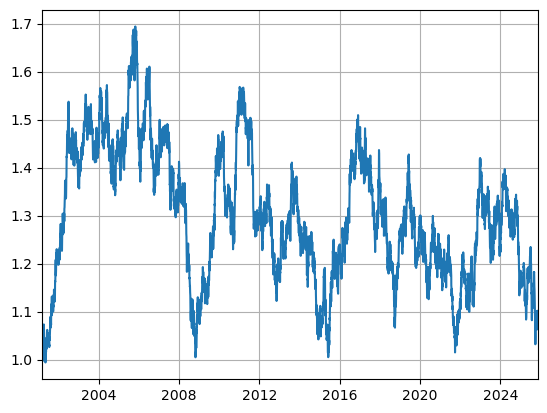

In [25]:
params =  [-.7, .1, .1, 0.2, .001, 0 , .05]
dt = 1/252

simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
#print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
plt.plot(date[300:],v1[300:]/v1[300])
plt.grid(True)
plt.autoscale(axis='x', tight=True)

In [50]:
initial_guess = [-.7, .1, .1, 0.2, .0001, 0 , .05]  # [rho, kappa, theta, sigma, lambda, mu_j, sigma_j]
delta = 0.1  # The value you want to add and subtract
lower_bounds = [-0.9, 0.001, 0.001, .01, .001, 0.001, .01]
upper_bounds = [0.9, .8, .05, .01, .01, .005, .1]
bounds = list(zip(lower_bounds, upper_bounds))
print(bounds)

[(-0.9, 0.9), (0.001, 0.8), (0.001, 0.05), (0.01, 0.01), (0.001, 0.01), (0.001, 0.005), (0.01, 0.1)]


In [51]:
lb = lower_bounds
ub = upper_bounds

bounds = list(zip(lb,ub))
param1_min, param1_max = bounds[0]
param2_min, param2_max = bounds[1]
param3_min, param3_max = bounds[2]
param4_min, param4_max = bounds[3]
param5_min, param5_max = bounds[4]
param6_min, param6_max = bounds[5]
param7_min, param7_max = bounds[6]

print(bounds)
print(lb)


[(-0.9, 0.9), (0.001, 0.8), (0.001, 0.05), (0.01, 0.01), (0.001, 0.01), (0.001, 0.005), (0.01, 0.1)]
[-0.9, 0.001, 0.001, 0.01, 0.001, 0.001, 0.01]


In [ ]:
!pip install deap
from deap import base, creator, tools, algorithms

# Create the 'creator' object
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


# Perform parameter estimation using minimize
options = {'maxiter': 1000,  # Maximum number of iterations
           'maxfev': 500   # Maximum number of function calls
                     }

creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

creator.create("FitnessMin", base.Fitness, weights=(1.0,))

# Define the individual representation, which includes the five parameters
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define the bounds for each parameter


# Create an individual with random values within the defined bounds
def create_individual():
    return [
        random.uniform(param1_min, param1_max),
        random.uniform(param2_min, param2_max),
        random.uniform(param3_min, param3_max),
        random.uniform(param4_min, param4_max),
        random.uniform(param5_min, param5_max),
        random.uniform(param6_min, param6_max),
        random.uniform(param7_min, param7_max),

    ]

# Example of creating an individual
individual = create_individual()
toolbox = base.Toolbox()
# Define parameter boundaries
#varbound = np.array([[-0.9, 0.9], [0.001, 5], [0.001, 2.0], [0.001, 2.0], [0.001, 5.0]])
#bounds = [(-.99, .99), (0.001,5.0), (.001, 2.0), (.001, 2.0), (.001,5.0)]

# Register functions for creating individuals and populations
nparams = 7
toolbox.register("attr_float", np.random.uniform, 0.01, .99)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=nparams)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register other DEAP functions
toolbox.register("mate", tools.cxBlend, alpha=0.2)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=4)

# Set the number of generations and other parameters for GA
ngen = 200
cxpb = 0.4  # Crossover probability
mutpb = 0.05  # Mutation probability

# Create a population of 10 individuals for GA with variable boundaries
population = toolbox.population(n=100)

# Define custom evaluation function for GA
def eval_individual(individual):
    params = individual
    fitness = likelihood1(params, price_series, dt)
    return (fitness,)  # Wrap the fitness value in a tuple

# Register the evaluate function in the toolbox
toolbox.register("evaluate", eval_individual)

# Manually assign fitness values to individuals in the population
for ind in population:
    ind.fitness.values = eval_individual(ind)

# Create a Hall of Fame object to store the best individual from GA
hof = tools.HallOfFame(1)

# Define the GA statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=stats, halloffame=hof, verbose=True)

# Get the best individual from the genetic algorithm
best_individual_ga = hof[0]




[notice] A new release of pip is available: 23.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
C:\Users\mcnel\Anaconda4\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\mcnel\Anaconda4\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min      
0  	0     	-0.584112
1  	38    	-0.581255


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]


2  	55    	nan      
3  	38    	-0.558552


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]


4  	39    	nan      


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  jump_size = abs(data[i] - data[i - 1])


5  	35    	nan      
6  	45    	-0.516559
7  	52    	-0.370819
8  	40    	-0.406896
9  	48    	-0.359947
10 	39    	-0.410447
11 	47    	-0.449165
12 	43    	-0.357479
13 	32    	-0.346197
14 	37    	-0.3422  
15 	29    	-0.34506 
16 	43    	-0.34448 
17 	31    	-0.424362
18 	39    	-0.339789
19 	37    	-0.340681
20 	38    	-0.358842
21 	53    	-0.342321
22 	45    	-0.336086
23 	58    	-0.33534 
24 	50    	-0.346331
25 	39    	-0.332709
26 	41    	-0.335145
27 	44    	-0.335251
28 	47    	-0.339873
29 	42    	-0.33371 
30 	27    	-0.334453
31 	49    	-0.331784
32 	53    	-0.474894
33 	34    	-0.331273
34 	48    	-0.731039
35 	50    	-0.926677
36 	38    	-0.588768
37 	39    	-0.337502
38 	43    	-0.356552
39 	56    	-0.386156
40 	43    	-0.361928
41 	45    	-0.330579
42 	44    	-0.648024
43 	41    	-0.584366
44 	46    	-0.353234
45 	37    	-0.33689 
46 	48    	-0.330531
47 	36    	-0.331039
48 	53    	-1.13046 


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]


49 	57    	nan      
50 	26    	nan      
51 	35    	-0.337409
52 	38    	-0.417537
53 	44    	-0.333739
54 	35    	-0.447071
55 	36    	-0.418575
56 	36    	-0.330355
57 	34    	-0.344912
58 	32    	-0.344156
59 	45    	-0.330319
60 	41    	-0.333527
61 	53    	-0.342046
62 	46    	-0.331428
63 	43    	-1.20037 
64 	44    	-0.33094 
65 	48    	-0.330684
66 	60    	-0.332624
67 	38    	-0.33669 
68 	49    	-0.332413
69 	47    	-0.328575
70 	40    	-0.331786
71 	40    	-0.443803
72 	42    	-0.506224
73 	44    	-0.340305
74 	41    	-0.371966
75 	40    	-0.336847
76 	56    	-0.328006
77 	31    	-0.328248
78 	49    	-0.328002
79 	54    	-0.327922
80 	48    	-0.338986
81 	30    	-1.4561  


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  jump_size = abs(data[i] - data[i - 1])


82 	46    	nan      
83 	49    	nan      
84 	40    	nan      


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  jump_size = abs(data[i] - data[i - 1])


85 	34    	nan      
86 	48    	-1.55934 
87 	42    	-0.339224
88 	48    	-0.337047
89 	45    	-1.0164  


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  jump_size = abs(data[i] - data[i - 1])


90 	35    	nan      
91 	37    	-0.327764
92 	49    	-1.19184 
93 	53    	-1.21088 
94 	41    	-0.33074 
95 	39    	-0.41729 
96 	51    	-0.328878
97 	42    	-0.423646
98 	45    	-0.429811
99 	30    	-0.327288
100	47    	-0.396714
101	38    	-0.326996
102	48    	-0.38557 
103	46    	-0.333387
104	47    	-0.326831
105	46    	-0.330273
106	39    	-0.328284
107	40    	-0.32915 
108	41    	-0.334055
109	42    	-0.330654
110	45    	-0.432545
111	42    	-0.361675
112	40    	-0.327378
113	39    	-0.326755
114	51    	-0.337168
115	32    	-0.548301


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]


116	32    	nan      
117	41    	nan      
118	32    	nan      
119	43    	nan      
120	52    	-0.699522
121	48    	-0.330823
122	40    	-0.326553
123	43    	-0.328749
124	50    	-0.612132
125	39    	-0.326547
126	52    	-0.353753
127	40    	-0.326553
128	41    	-0.329521
129	43    	-0.326619
130	43    	-0.326546
131	42    	-0.334061
132	52    	-0.33164 
133	46    	-0.327709
134	42    	-0.328837
135	30    	-0.327749
136	54    	-0.332728
137	50    	-0.362966
138	47    	-0.333617
139	37    	-0.327959


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  jump_size = abs(data[i] - data[i - 1])


140	48    	nan      


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]


141	37    	nan      


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  jump_size = abs(data[i] - data[i - 1])


142	43    	nan      


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  jump_size = abs(data[i] - data[i - 1])


143	40    	nan      
144	26    	nan      


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  jump_size = abs(data[i] - data[i - 1])
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]


145	41    	nan      


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  jump_size = abs(data[i] - data[i - 1])
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in sca

146	30    	nan      


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  jump_size = abs(data[i] - data[i - 1])


147	48    	nan      


C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: invalid value encountered in accumulate
  return bound(*args, **kwds)
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:57: RuntimeWarning: overflow encountered in exp
  v[t] = np.log(1.0 + np.exp(v[t]))
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1339580997.py:56: RuntimeWarning: invalid value encountered in scalar add
  v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
C:\Users\mcnel\AppData\Local\Temp\ipykernel_9136\1693791090.py:8: RuntimeWarning: invalid value encounter

148	46    	nan      
149	50    	-0.329284
150	40    	-0.326546
151	49    	-0.432506
152	41    	-0.326652
153	41    	-0.335236
154	40    	-0.988169
155	35    	-0.326754
156	38    	-0.329715
157	39    	-0.461921
158	47    	-0.41948 
159	40    	-0.326608
160	44    	-0.328275
161	36    	-0.51043 
162	50    	-0.377909
163	52    	-0.332631
164	48    	-0.326944
165	46    	-0.333671
166	33    	-0.330046
167	41    	-0.428585
168	40    	-0.33557 
169	40    	-0.339975
170	56    	-0.329746
171	52    	-0.327351
172	34    	-0.332635
173	52    	-0.329736
174	43    	-0.326744
175	49    	-0.426206
176	42    	-0.386119
177	33    	-0.3275  
178	50    	-0.420157
179	39    	-0.408067
180	39    	-0.420956
181	40    	-0.327634


In [ ]:
print(hof[0])
params = hof[0]
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
window_size = 20
start = 300
# Calculate the rolling window average
v_smooth = np.convolve(v1, np.ones(window_size) / window_size, mode='valid')
v_smooth = v_smooth
plt.plot(date[start+window_size-1:],v_smooth[start:]/v_smooth[start])
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('SVJD Process for Genetic Algorithm Estimation')

In [33]:
print(hof[0])

[-0.05733167544378508, 2.0545839447578294, 0.0005640269994850065, 1.339151251377992, 0.30621453359982453, 0.6321739889947798, 0.17781206179406225]


In [27]:
import numpy as np
from scipy.optimize import dual_annealing

# Define the objective function to minimize

# Define the bounds for each variable
initial_guess = hof[0]
lower_bounds = [-0.9, 1, 0.00011, .5, .1, 0.4, .0001]
upper_bounds = [0.1, 3, .05, 1.5, 1.5, .9, .1]
bounds = list(zip(lower_bounds, upper_bounds))

#lower_bounds = initial_guess * (1-delta)
#upper_bounds = initial_guess * (1+delta)
bounds = list(zip(lower_bounds, upper_bounds))

# Run dual_annealing
result = dual_annealing(
    func= likelihood,
    bounds=bounds,
    maxiter=200,
    args=(price_series, dt),  # Pass the long series as an argument
    initial_temp=100,
    seed= 76,

)

# Print the results
print("Optimal Solution:", result.x)
print("Optimal Value:", result.fun)

Optimal Solution: [-8.84934071e-01  2.99861977e+00  1.10000000e-04  9.49786832e-01
  3.13804578e-01  6.25461337e-01  1.00000000e-04]
Optimal Value: 0.5269151421672992


[-8.84934071e-01  2.99861977e+00  1.10000000e-04  9.49786832e-01
  3.13804578e-01  6.25461337e-01  1.00000000e-04]
21.715411286954218
[[0.52691514]]


Text(0.5, 1.0, 'SVJD Process for Simulated Annealing')

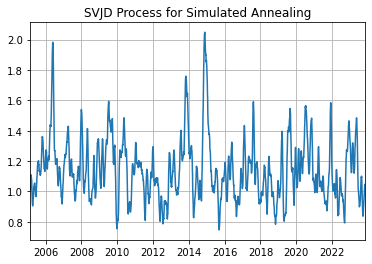

In [28]:
params = result.x
print(params)
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
window_size = 20
start = 300
# Calculate the rolling window average
v_smooth = np.convolve(v1, np.ones(window_size) / window_size, mode='valid')
v_smooth = v_smooth
plt.plot(date[start+window_size-1:],v_smooth[start:]/v_smooth[start])
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('SVJD Process for Simulated Annealing')

In [29]:
!pip install pyswarm
import numpy as np
from pyswarm import pso

# Define the objective function to be minimized
params = result.x
initial_guess = params
lower_bounds = [-0.7, 1.5, 0.001, 1.0, .1, 0.1, .001]
upper_bounds = [.3, 3, .01, 2, .4, .5, .01]
bounds = list(zip(lower_bounds, upper_bounds))
bounds = list(zip(lower_bounds,  upper_bounds))


lb = lower_bounds
ub = upper_bounds
c1 = 1  # Cognitive parameter
c2 = 1  # Social parameter
w = 0.5  # Inertia weight
maxiter = 50 # Maximum number of iterations

# Perform PSO optimization with additional arguments and defined parameters
parameters, value = pso(likelihood, lb, ub, args=(price_series, dt), debug=True, swarmsize=50, maxiter=maxiter, phip=c1, phig=c2, omega=w)

No constraints given.


Best after iteration 1: [-0.02907651  2.71432307  0.00649334  1.36542671  0.28935222  0.17090081
  0.00544395] 0.5433360563996291
Best after iteration 2: [-0.02907651  2.71432307  0.00649334  1.36542671  0.28935222  0.17090081
  0.00544395] 0.5433360563996291
New best for swarm at iteration 3: [0.11163354 2.87057177 0.00714629 1.05608218 0.35313133 0.30644725
 0.00599568] [[0.54292125]]
New best for swarm at iteration 3: [-0.01976796  3.          0.00594224  1.19584341  0.28849323  0.31929884
  0.00763996] [[0.53906874]]
Best after iteration 3: [-0.01976796  3.          0.00594224  1.19584341  0.28849323  0.31929884
  0.00763996] [[0.53906874]]
New best for swarm at iteration 4: [0.0280432  3.         0.00459552 1.14033501 0.30593246 0.32019284
 0.0082398 ] [[0.53902634]]
Best after iteration 4: [0.0280432  3.         0.00459552 1.14033501 0.30593246 0.32019284
 0.0082398 ] [[0.53902634]]
New best for swarm at iteration 5: [-0.02720359  3.          0.00374245  1.11505557  0.32884298  0

Best after iteration 26: [-0.2579877   3.          0.00670046  1.1038015   0.33691442  0.5
  0.00419523] [[0.53382176]]
New best for swarm at iteration 27: [-0.25801165  3.          0.00659342  1.10379811  0.33657075  0.5
  0.00412155] [[0.53382132]]
New best for swarm at iteration 27: [-0.2581036   3.          0.00665653  1.10377118  0.3368307   0.5
  0.00412156] [[0.5338213]]
New best for swarm at iteration 27: [-0.25809027  3.          0.00654908  1.10380794  0.3369569   0.5
  0.00413612] [[0.53382105]]
Best after iteration 27: [-0.25809027  3.          0.00654908  1.10380794  0.3369569   0.5
  0.00413612] [[0.53382105]]
New best for swarm at iteration 28: [-0.25804012  3.          0.00648359  1.1037647   0.33693824  0.5
  0.00410762] [[0.53382089]]
Best after iteration 28: [-0.25804012  3.          0.00648359  1.1037647   0.33693824  0.5
  0.00410762] [[0.53382089]]
New best for swarm at iteration 29: [-0.25811875  3.          0.00648572  1.10373874  0.33694965  0.5
  0.00409506] [

In [30]:
print(parameters)

[-0.33855209  3.          0.01        1.          0.31037509  0.5
  0.009849  ]


[-0.33855209  3.          0.01        1.          0.31037509  0.5
  0.009849  ]
21.0458924050931
[[0.52887386]]


Text(0.5, 1.0, 'SVJD Process for Partical Swarm Estimation')

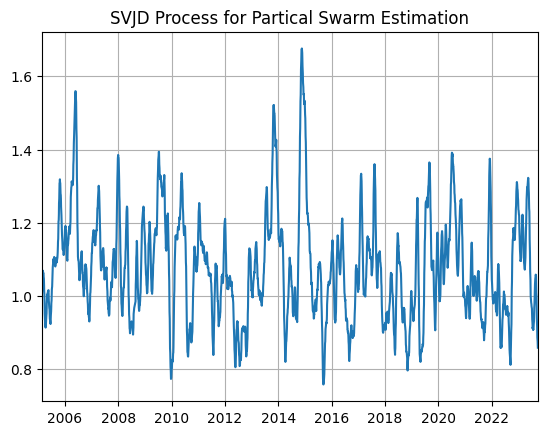

In [31]:
params = parameters
print(params)
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
window_size = 20
start = 300
# Calculate the rolling window average
v_smooth = np.convolve(v1, np.ones(window_size) / window_size, mode='valid')
v_smooth = v_smooth
plt.plot(date[start+window_size-1:],v_smooth[start:]/v_smooth[start])
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('SVJD Process for Partical Swarm Estimation')

$\textbf{Options for Minimzation}$

- 'BFGS': Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm is a quasi-Newton method used for unconstrained optimization. It approximates the Hessian matrix using gradient information.

- 'L-BFGS-B': Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS-B) is a variant of BFGS for bounded variable problems. It is suitable for problems with both constraints and bounds.

- 'Nelder-Mead': Nelder-Mead simplex algorithm is a derivative-free optimization method used for unconstrained problems. It is suitable for problems where derivatives are not available or difficult to compute.

- 'Powell': Powell’s method is a conjugate direction method. It doesn't require derivatives, and it can be used for both constrained and unconstrained optimization.

- 'CG': Conjugate Gradient method is suitable for unconstrained optimization. It's often used when the objective function is quadratic.

- 'Newton-CG': Newton-Conjugate Gradient method is used for unconstrained optimization. It requires the Hessian (second derivative) of the objective function.

- 'TNC': Truncated Newton Conjugate-Gradient method is for bounded constrained optimization. It approximates the Hessian using finite differences.

- 'trust-ncg': Trust-Region Newton-Conjugate Gradient method is used for unconstrained optimization. It requires the Hessian of the objective function.

- 'trust-exact': Trust-Region Exact method is a trust-region algorithm for unconstrained optimization that uses exact second derivatives (Hessian).

- 'trust-krylov': Trust-Region Krylov method is a trust-region algorithm for unconstrained optimization that uses an approximate Hessian.

- 'trust-constr': Trust Region Constrained method is for constrained optimization with bounds and linear constraints. It uses a trust-region approach.

- 'dogleg': Dogleg method is for unconstrained optimization. It combines steepest-descent and trust-region methods.

- 'trust-ncg': Trust-Region Newton-Conjugate Gradient method is for unconstrained optimization. It requires the Hessian of the objective function.

- 'trust-krylov': Trust-Region Krylov method is for unconstrained optimization. It uses Krylov subspace methods to approximate the Hessian.

- 'trust-region': Generic trust-region method that allows you to specify the Hessian approximation method using the hess parameter.

- 'basinhopping': Basin-Hopping algorithm is a global optimization method that combines local minimization with random sampling of starting points.

- 'shgo': SHGO (Simplicial Homology Global Optimization) is a global optimization method for both constrained and unconstrained problems.

In [33]:
#  params: [rho, kappa, theta, sigma, lambda_J, mu_J, sigma_J]
#import numpy as np
np.seterr(over='ignore', divide='ignore', invalid='ignore')  # Ignore overflow and other warnings

initial_guess = parameters
delta = 0.2 # The value you want to add and subtract
lower_bound = [-.7, 1.5, .00001, .8, .01, .4, .001]

upper_bound = [1.1, 4, .01, 1.5, .4, .7, .02]
bounds = list(zip(lower_bound, upper_bound))

result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='Powell', options={'maxiter':200})

#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='Powell', options={'maxiter':200})
#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='TNC', options={'maxiter':200})
#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='SLSQP', options={'maxiter':200})
#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='COBYLA', options={'maxiter':200})
#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='L-BFGS-B', options={'maxiter':200})
#initial_guess = result.x
#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='CG', options={'maxiter':200})

# Extract estimated parameters
rho_est, kappa_est, theta_est, sigma_est, lambda_J_est, mu_J_est, sigma_J_est = result.x
print(f"Estimated Parameters:")
print(f"Rho: {rho_est}")
print(f"Kappa: {kappa_est}")
print(f"Theta: {theta_est}")
print(f"Sigma: {sigma_est}")
print(f"lambda: {lambda_J_est}")
print(f"mu_J: {mu_J_est}")
print(f"sigma_J: {sigma_J_est}")






Estimated Parameters:
Rho: -0.3385164291328831
Kappa: 3.999961725524757
Theta: 5.789140106605625e-05
Sigma: 1.1516850017691485
lambda: 0.10166862735871524
mu_J: 0.6059167219761047
sigma_J: 0.019940993219712305


[-3.38516429e-01  3.99996173e+00  5.78914011e-05  1.15168500e+00
  1.01668627e-01  6.05916722e-01  1.99409932e-02]
20.500365571785803
[[0.53577076]]


Text(0.5, 1.0, 'SVJD Process for BFGS Gradient Method')

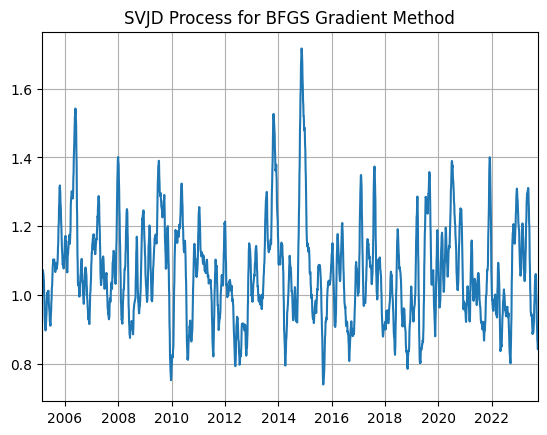

In [34]:
params = result.x
print(params)
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
window_size = 20
start = 300
# Calculate the rolling window average
v_smooth = np.convolve(v1, np.ones(window_size) / window_size, mode='valid')
v_smooth = v_smooth
plt.plot(date[start+window_size-1:],v_smooth[start:]/v_smooth[start])
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('SVJD Process for BFGS Gradient Method')


(array([1.000e+00, 1.000e+00, 3.000e+00, 1.000e+01, 4.764e+03, 3.560e+02,
        2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([-19.91048543, -15.70183471, -11.49318399,  -7.28453328,
         -3.07588256,   1.13276816,   5.34141887,   9.55006959,
         13.75872031,  17.96737102,  22.17602174]),
 <BarContainer object of 10 artists>)

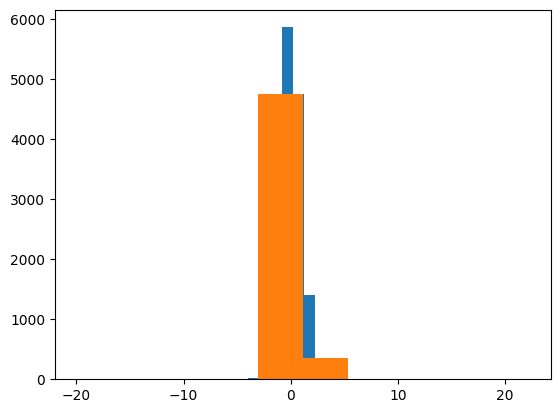

In [35]:
actual_returns = np.diff(np.log(price_series))

simulated_returns = simulated_returns[1:]
plt.hist(simulated_returns/np.std(simulated_returns))
plt.hist(actual_returns/np.std(actual_returns))



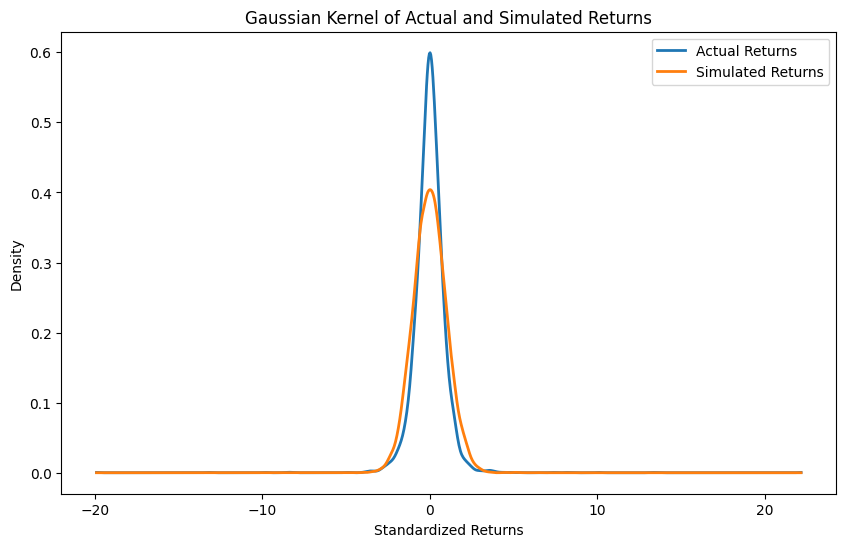

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming you have actual_returns and simulated_returns data
actual_returns = np.diff(np.log(price_series))
simulated_returns = simulated_returns[1:]

# Calculate standardized returns
actual_returns_std = actual_returns / np.std(actual_returns)
simulated_returns_std = simulated_returns / np.std(simulated_returns)

# Create a density estimator for actual_returns
actual_kde = gaussian_kde(actual_returns_std)

# Create a density estimator for simulated_returns
simulated_kde = gaussian_kde(simulated_returns_std)

# Create a range of values for the x-axis
x = np.linspace(min(min(actual_returns_std), min(simulated_returns_std)),
                max(max(actual_returns_std), max(simulated_returns_std)), 1000)

# Plot KDE for actual_returns
plt.figure(figsize=(10, 6))
plt.plot(x, actual_kde(x), label='Actual Returns', linewidth=2)

# Plot KDE for simulated_returns
plt.plot(x, simulated_kde(x), label='Simulated Returns', linewidth=2)

# Set labels and legend
plt.xlabel('Standardized Returns')
plt.ylabel('Density')
plt.legend()
plt.title('Gaussian Kernel of Actual and Simulated Returns')

# Show the plot
plt.show()






In [37]:
import torch
import torch.nn.functional as F



def torch_likelihood(params, price_series, dt):
    import torch
    import torch.nn.functional as F
    #if not isinstance(params, torch.Tensor):
    #    params = torch.tensor(params, dtype=torch.float64)
    #params = params.detach().numpy()  # Convert to NumPy array if needed
    simulated_price, simulated_returns, v1, sse, rsq, error = heston_model(params, price_series, dt)
    #price_series = torch.tensor(price_series, dtype=torch.float64, requires_grad = False)
    actual_returns = 100 * torch.diff(torch.log(price_series))
    model_returns = 100 * simulated_returns

    model_returns =  torch.tensor(model_returns, dtype=torch.float64, requires_grad=False)
    T = len(actual_returns)
    residuals = error
    residuals = torch.tensor(residuals, dtype=torch.float64, requires_grad = False)
    v1 =  torch.tensor(v1, dtype=torch.float64, requires_grad = False)
    dt = torch.tensor(dt, dtype=torch.float64, requires_grad = False)
    Log_likelihood = -0.5 * torch.sum(residuals**2) - 0.5 * torch.tensor(np.pi, dtype=torch.float64, requires_grad = False) * torch.sum(v1)

    # Calculate moments using PyTorch operations
    actual_moments = torch.tensor([torch.mean(actual_returns), torch.mean(actual_returns**2),
                                    torch.mean(actual_returns**3), torch.mean(actual_returns**4)], dtype=torch.float64, requires_grad = False)
    model_moments = torch.tensor([torch.mean(model_returns), torch.mean(model_returns**2),
                                   torch.mean(model_returns**3), torch.mean(model_returns**4)], dtype=torch.float64, requires_grad = False)

    actual_moments = actual_moments.view(1, 4)
    model_moments = model_moments.view(1, 4)

    # Calculate autocorrelations using PyTorch operations
    actual_returns_sq = actual_returns**2
    model_returns_sq = model_returns**2

    max_lag = 5

    actual_autocorr = []
    actual_autocorr_sq = []
    model_autocorr = []
    model_autocorr_sq = []






    for lag in range(1, max_lag + 1):
    # Calculate cross-correlation using conv1d for actual_returns

        shifted_model_returns = torch.roll(model_returns, shifts=lag, dims=0)
        cross_corr_model = F.conv1d(model_returns.view(1, 1, -1), shifted_model_returns.view(1, 1, -1).flip(2), padding=0)
        model_autocorr1 = cross_corr_model.squeeze() / len(model_returns)
        model_autocorr.append(model_autocorr1)

        shifted_actual_returns = torch.roll(actual_returns, shifts=lag, dims=0)
        cross_corr_actual = F.conv1d(actual_returns.view(1, 1, -1), shifted_actual_returns.view(1, 1, -1).flip(2), padding=0)
        actual_autocorr1 = cross_corr_actual.squeeze() / len(actual_returns)
        actual_autocorr.append(model_autocorr1)

        shifted_model_returns_sq = torch.roll(model_returns_sq, shifts=lag, dims=0)
        cross_corr_model_sq = F.conv1d(model_returns_sq.view(1, 1, -1), shifted_model_returns_sq.view(1, 1, -1).flip(2), padding=0)
        model_autocorr1_sq = cross_corr_model_sq.squeeze() / len(model_returns_sq)
        model_autocorr_sq.append(model_autocorr1_sq)

        shifted_actual_returns_sq = torch.roll(actual_returns_sq, shifts=lag, dims=0)
        cross_corr_actual_sq = F.conv1d(actual_returns_sq.view(1, 1, -1), shifted_actual_returns_sq.view(1, 1, -1).flip(2), padding=0)
        actual_autocorr1_sq = cross_corr_actual_sq.squeeze() / len(actual_returns_sq)
        actual_autocorr_sq.append(model_autocorr1_sq)






    threshold = 2.576 * torch.std(actual_returns)
    actual_jumps, actual_jump_size = count_jumps_and_average_jump_size(actual_returns, threshold)
    model_jumps, model_jump_size = count_jumps_and_average_jump_size(model_returns, threshold)
    import torch

# Convert Pandas Series to PyTorch tensors
    model_jumps = torch.tensor(model_jumps, dtype=torch.float64).clone().detach()
    model_jump_size = torch.tensor(model_jump_size, dtype=torch.float64).clone().detach()
    actual_jumps = torch.tensor(actual_jumps, dtype=torch.float64).clone().detach()
    actual_jump_size = torch.tensor(actual_jump_size, dtype=torch.float64).clone().detach()

    ACTUAL_MOMENTS = [actual_moments, actual_jumps, actual_jump_size, actual_autocorr, actual_autocorr_sq]
    MODEL_MOMENTS = [model_moments, model_jumps, model_jump_size, model_autocorr, model_autocorr_sq]

    # Concatenate all arrays within ACTUAL_MOMENTS and MODEL_MOMENTS horizontally
 #   ACTUAL_MOMENTS = torch.cat([arr.view(1, -1) if len(arr.shape) == 1 else arr for arr in ACTUAL_MOMENTS], dim=1)
 #   MODEL_MOMENTS = torch.cat([arr.view(1, -1) if len(arr.shape) == 1 else arr for arr in MODEL_MOMENTS], dim=1)

    ACTUAL_MOMENTS = [arr if isinstance(arr, torch.Tensor) else torch.tensor(arr) for arr in ACTUAL_MOMENTS]
    MODEL_MOMENTS = [arr if isinstance(arr, torch.Tensor) else torch.tensor(arr) for arr in MODEL_MOMENTS]

# Concatenate all tensors within ACTUAL_MOMENTS and MODEL_MOMENTS horizontally
    ACTUAL_MOMENTS = torch.cat([arr.view(1, -1) for arr in ACTUAL_MOMENTS], dim=1)
    MODEL_MOMENTS = torch.cat([arr.view(1, -1) for arr in MODEL_MOMENTS], dim=1)

    ERROR_MOMENTS = ACTUAL_MOMENTS - MODEL_MOMENTS
    num_moments = ERROR_MOMENTS.shape[1]
    #ERROR_MOMENTS = torch.tensor([ERROR_MOMENTS])
    ERROR_MOMENTS_T = ERROR_MOMENTS.t()

# Compute the covariance matrix
    COVARIANCE_MOMENTS = torch.mm(ERROR_MOMENTS_T, ERROR_MOMENTS_T.t())

    SIGMA_MOMENTS = torch.mm(ERROR_MOMENTS, ERROR_MOMENTS.t())
    SIGMA_MOMENTS1 = torch.diag(torch.diag(SIGMA_MOMENTS))
    SIGMA_MOMENTS2 = torch.sqrt(SIGMA_MOMENTS1)
    SIGMA_MOMENTS3 = torch.inverse(SIGMA_MOMENTS2)
    ERROR_TOTAL1 = torch.log(torch.mm(ERROR_MOMENTS.t(), torch.mm(SIGMA_MOMENTS3, ERROR_MOMENTS)))
    ERROR_TOTAL2 = torch.log(torch.sum(ERROR_MOMENTS**2))
    log_likelihood1 = ERROR_TOTAL1.sum()  # Adjust as per your likelihood function
    log_likelihood = log_likelihood1.clone().detach().requires_grad_(True)

    return log_likelihood  # Return negative log-likelihood for minimization


In [38]:
#!pip install torch

from torch.optim import Adam
from torch.optim import SGD


# Define your objective function with additional arguments

params = result.x
# Additional data and parameters
params = torch.tensor(params, requires_grad=True, dtype=torch.float64)
price_series = torch.tensor(price_series, dtype=torch.float64, requires_grad = False)

# Create an Adam optimizer
#optimizer = Adam([params], lr=0.01)  # Wrap params in a list
optimizer = SGD([params], lr=0.01)
#optimizer = RMSprop([params], lr=0.01)
#optimizer = Adagrad([params], lr=0.01)
#optimizer = Adadelta([params], lr=1.0)
#optimizer  = LBFGS([params], lr=0.01)
#optimizer =  SparseAdam([params], lr=0.001)
#optimizer = AdamW([params], lr=0.01)
#optimizer  = Rprop([params], lr=0.01)

# Number of optimization steps
num_steps = 500

# Optimization loop
for _ in range(num_steps):
    optimizer.zero_grad()
    loss = torch_likelihood(params, price_series, dt)
    loss.backward()
    optimizer.step()

# Extract the optimized parameters as a NumPy array
optimized_params = params.detach().numpy()

# Print the result
print("Optimized parameters:", optimized_params)

<ipython-input-37-836ad269cb78>:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_jump_size = torch.tensor(model_jump_size, dtype=torch.float64).clone().detach()
<ipython-input-37-836ad269cb78>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actual_jump_size = torch.tensor(actual_jump_size, dtype=torch.float64).clone().detach()


Optimized parameters: [-3.38516429e-01  3.99996173e+00  5.78914011e-05  1.15168500e+00
  1.01668627e-01  6.05916722e-01  1.99409932e-02]


In [39]:
print(optimized_params)

[-3.38516429e-01  3.99996173e+00  5.78914011e-05  1.15168500e+00
  1.01668627e-01  6.05916722e-01  1.99409932e-02]


[-3.38516429e-01  3.99996173e+00  5.78914011e-05  1.15168500e+00
  1.01668627e-01  6.05916722e-01  1.99409932e-02]
21.254345852007354
[[0.53577076]]


Text(0.5, 1.0, 'SVJD Process for Adam - Tensor Flow Gradient Method')

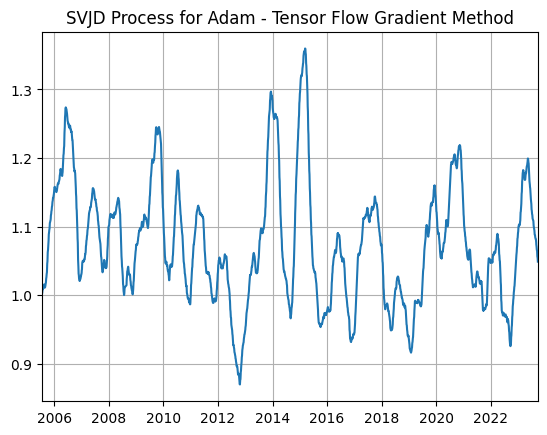

In [40]:
params = optimized_params
print(params)
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
window_size = 126
start = 300
# Calculate the rolling window average
v_smooth = np.convolve(v1, np.ones(window_size) / window_size, mode='valid')
v_smooth = v_smooth
plt.plot(date[start+window_size:],v_smooth[start:]/v_smooth[start])
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('SVJD Process for Adam - Tensor Flow Gradient Method')




In [5]:
!pip install numpy
import numpy as np

# ======================================================
# 1. Bates (SVJD) characteristic function
# ======================================================
def bates_charfun(u, T, S0, r_d, r_f, 
                  rho, kappa, theta, sigma_v, v0,
                  lam, muJ, sigmaJ):
    
    iu = 1j * u
    
    # Heston diffusion part
    alpha = -0.5 * (u**2 + iu)
    beta  = kappa - rho * sigma_v * iu
    gamma = 0.5 * sigma_v**2
    
    d = np.sqrt(beta**2 - 4 * alpha * gamma)
    g = (beta - d) / (beta + d)

    exp_dT = np.exp(-d*T)
    one_minus_gexp = 1 - g * exp_dT
    one_minus_g    = 1 - g

    C = (r_d - r_f) * iu * T \
      + (kappa * theta / gamma) * (
            (beta - d)*T - 2*np.log(one_minus_gexp/one_minus_g)
        )

    D = ((beta - d) / gamma) * ((1 - exp_dT) / one_minus_gexp)

    # Jump part: lognormal jumps
    jump_cf = np.exp(
        lam * T * (np.exp(iu*muJ - 0.5*sigmaJ**2*u**2) - 1)
    )

    phi = np.exp(C + D*v0 + iu*np.log(S0)) * jump_cf
    return phi


# ======================================================
# 2. P1 and P2 probability integrals
# ======================================================
def _Pj(j, S0, K, T, r_d, r_f,
        rho, kappa, theta, sigma_v, v0,
        lam, muJ, sigmaJ,
        umax=200, N=4000):

    u = np.linspace(1e-6, umax, N)

    if j == 1:
        phi = bates_charfun(u - 1j, T, S0, r_d, r_f,
                            rho, kappa, theta, sigma_v, v0,
                            lam, muJ, sigmaJ)
        numerator   = np.exp(-1j*u*np.log(K)) * phi
        denominator = 1j*u * S0 * np.exp(-r_f*T)
    else:
        phi = bates_charfun(u, T, S0, r_d, r_f,
                            rho, kappa, theta, sigma_v, v0,
                            lam, muJ, sigmaJ)
        numerator   = np.exp(-1j*u*np.log(K)) * phi
        denominator = 1j*u

    integrand = numerator/denominator
    integrand = np.real(integrand)

    # FIXED HERE
    val = 0.5 + (1/np.pi) * np.trapezoid(integrand, u)
    return val



# ======================================================
# 3. FX call price under Bates
# ======================================================
def bates_price_fx(S0, K, T, r_d, r_f, params):
    rho, kappa, theta, sigma_v, lam, muJ, sigmaJ = params
    v0 = theta  # You were using θ as the initial variances in estimation

    P1 = _Pj(1, S0, K, T, r_d, r_f,
             rho, kappa, theta, sigma_v, v0,
             lam, muJ, sigmaJ)

    P2 = _Pj(2, S0, K, T, r_d, r_f,
             rho, kappa, theta, sigma_v, v0,
             lam, muJ, sigmaJ)

    call = S0*np.exp(-r_f*T)*P1 - K*np.exp(-r_d*T)*P2
    return call


In [6]:
params = np.array([
    -0.338516429,   # rho
    3.99996173,     # kappa
    5.78914011e-05, # theta
    1.15168500,     # sigma_v
    0.101668627,    # lambda
    0.605916722,    # mu_J
    0.0199409932    # sigma_J
])


In [7]:
S0 = 1.08
K  = 1.10
T  = 0.5
r_d = 0.04  # USD rate
r_f = 0.02  # EUR rate

price = bates_price_fx(S0, K, T, r_d, r_f, params)
print(price)


0.014429665185276996


In [9]:

import numpy as np
from math import erf, sqrt, log, exp

def bs_call_fx(S0, K, T, r_d, r_f, sigma):
    """
    Black–Scholes European call on FX:
    S0  : spot FX (domestic price of 1 unit foreign)
    K   : strike
    T   : maturity (in years)
    r_d : domestic rate
    r_f : foreign rate
    sigma : constant (annualized) volatility
    """

    if sigma <= 0:
        raise ValueError("sigma must be positive")

    d1 = (log(S0 / K) + (r_d - r_f + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    # Standard normal CDF using error function
    def N(x):
        return 0.5 * (1.0 + erf(x / sqrt(2.0)))

    call = S0 * exp(-r_f * T) * N(d1) - K * exp(-r_d * T) * N(d2)
    return call


In [10]:
# Common inputs
S0  = 1.08
K   = 1.10
T   = 0.5
r_d = 0.04  # USD rate
r_f = 0.02  # EUR rate

# Bates price (assuming you already defined bates_price_fx and params)
bates_price = bates_price_fx(S0, K, T, r_d, r_f, params)

# For Black–Scholes, pick sigma based on Bates parameters
theta = params[2]
sigma_bs = np.sqrt(theta)   # simple mapping: constant vol = sqrt(long-run variance)

bs_price = bs_call_fx(S0, K, T, r_d, r_f, sigma_bs)

print("Bates call price:        ", bates_price)
print("Black–Scholes call price:", bs_price)
print("Black–Scholes sigma used:", sigma_bs)


Bates call price:         0.014429665185276996
Black–Scholes call price: 0.0001502680740080864
Black–Scholes sigma used: 0.007608639898168398


# Black–Scholes and Bates Option Pricing Models

This section summarizes the economic structure and option pricing setup for the Black–Scholes model and the Bates stochastic volatility with jumps (SVJD) model. The Bates model extends Black–Scholes by allowing for stochastic volatility and lognormal jumps, producing more realistic return dynamics and implied volatility patterns.

---

# 1. Black–Scholes Option Pricing Model

## 1.1 Price Dynamics

The Black–Scholes model assumes that the price of the underlying asset follows geometric Brownian motion:

$$
dS_t = \mu S_t\,dt + \sigma S_t\, dW_t
$$

Under the risk-neutral measure:

$$
dS_t = r S_t\,dt + \sigma S_t\, dW_t^{Q}.
$$

Here $r$ is the risk-free rate and $\sigma$ is constant volatility.

---

## 1.2 Distribution of Log Prices

Solving the diffusion process yields:

$$
S_T = S_0 \exp\left[\left(r - \tfrac12\sigma^2\right)T + \sigma\sqrt{T}\,Z\right],
\qquad Z \sim N(0,1).
$$

Thus,

$$
\ln S_T \sim N\Big(\ln S_0 + (r - \tfrac12\sigma^2)T,\;\sigma^2 T\Big).
$$

This closed-form distribution leads to an analytical option pricing formula.

---

## 1.3 European Call Option Formula

A European call option price is:

$$
C = e^{-rT}\,\mathbb{E}^Q[(S_T - K)^+].
$$

Evaluating the expectation gives the Black–Scholes formula:

$$
C = S_0 N(d_1) - K e^{-rT} N(d_2),
$$

with

$$
d_1 = \frac{\ln(S_0/K) + (r + \tfrac12\sigma^2)T}{\sigma\sqrt{T}}, 
\qquad 
d_2 = d_1 - \sigma\sqrt{T}.
$$

---

## 1.4 Limitations of Black–Scholes

The Black–Scholes assumptions imply:

- lognormal returns
- constant volatility
- no jumps
- no volatility clustering
- symmetric distribution

These features do not match empirical FX or equity return properties and cannot reproduce implied volatility smiles and skews.

---

# 2. Bates Model (Stochastic Volatility with Jumps)

The Bates model combines Heston stochastic volatility with Merton-style lognormal jumps. It captures time-varying volatility, return skewness, leptokurtosis, and jump risk premia.

---

# 2.1 Price Dynamics Under the Risk-Neutral Measure

For FX, where $r_d$ is the domestic interest rate and $r_f$ is the foreign rate:

$$
dS_t = (r_d - r_f - \lambda k_J)\,S_t\,dt 
     + \sqrt{v_t}\,S_t\, dW_t^S 
     + (J_t - 1)\,S_{t^-}\, dN_t.
$$

The variance process follows the Heston square-root diffusion:

$$
dv_t = \kappa(\theta - v_t)\,dt + \sigma_v \sqrt{v_t}\, dW_t^v,
$$

with correlation:

$$
dW_t^S\, dW_t^v = \rho \, dt.
$$

---

# 2.2 Jump Specification

Jumps arrive according to a Poisson process $N_t$ with intensity $\lambda$. Jump sizes are lognormal:

$$
\ln J_t \sim N(\mu_J,\;\sigma_J^2).
$$

The jump compensator ensures martingale pricing:

$$
k_J = \mathbb{E}[J - 1] 
    = \exp\left(\mu_J + \tfrac12 \sigma_J^2\right) - 1.
$$

Thus the drift adjustment $-\lambda k_J$ is required under $Q$.

---

# 2.3 Bates Characteristic Function

Although the distribution of $\ln S_T$ is not available in closed form, the characteristic function is known. It consists of:

1. the Heston characteristic function for stochastic volatility, and  
2. the jump component:

$$
\exp\Big( \lambda T \big( \exp(iu\mu_J - \tfrac12\sigma_J^2 u^2) - 1 \big) \Big).
$$

This characteristic function enables pricing by Fourier inversion.

---

# 2.4 Fourier-Based Option Pricing

The price of a European call option is:

$$
C = S_0 e^{-r_f T} P_1 - K e^{-r_d T} P_2,
$$

where the risk-neutral probabilities $P_1$ and $P_2$ are computed by:

$$
P_j 
= \frac12 
  + \frac{1}{\pi}
    \int_0^\infty 
    \operatorname{Re}\left[
    \frac{e^{-iu\ln K}\,\phi_j(u)}{iu}
  \right]\,du.
$$

The characteristic functions $\phi_1(u)$ and $\phi_2(u)$ differ by a shift $u \rightarrow u - i$.

This Fourier pricing framework has no closed-form solution but can be evaluated accurately by numerical integration.

---

# 2.5 Advantages of the Bates Model

The Bates model captures:

- stochastic volatility 
- negative return–volatility correlation (leverage effect)
- jumps in prices
- heavy tails and skewness
- volatility clustering
- realistic implied volatility smiles and skews
- more accurate FX return dynamics

Compared to Black–Scholes, Bates provides a flexible and empirically realistic framework for both underlying price behavior and option pricing.

---

# 3. Summary

Black–Scholes is analytically simple and widely used but relies on restrictive assumptions about volatility and return distributions. The Bates stochastic volatility with jumps model extends Black–Scholes by including both stochastic volatility and jump risk, generating a much richer distribution of returns and more realistic option prices.

The pricing functions implemented in this notebook use the Bates characteristic function and Fourier-based integrals to compute $P_1$, $P_2$, and the final option price:

$$
C = S_0 e^{-r_f T} P_1 - K e^{-r_d T} P_2.
$$


# Comparison of Bates and Black–Scholes Option Prices

Using the parameters estimated for the Bates SVJD model, we obtain:

- Bates call price:  
  $$C_{\text{Bates}} \approx 0.01443$$

- Black–Scholes call price (with $\sigma = \sqrt{\theta}$):  
  $$C_{\text{BS}} \approx 0.00015$$

- Black–Scholes volatility used:  
  $$\sigma_{\text{BS}} = \sqrt{\theta} \approx 0.00761$$

This large difference is economically meaningful and follows directly from the structure of each model.

---

## 1. Why Black–Scholes Gives an Extremely Small Price

In Black–Scholes, the underlying follows geometric Brownian motion:

$$
dS_t = (r_d - r_f) S_t\, dt + \sigma S_t\, dW_t,
$$

with **constant** volatility $\sigma$.

Using  
$$\theta = 5.789\times 10^{-5}, \qquad \sigma_{\text{BS}} = \sqrt{\theta} \approx 0.0076,$$

the model implies that annualized volatility is less than 1 percent.

This means:

- price movements are extremely small  
- the distribution of $S_T$ is very tight  
- the probability that  
  $$S_T > K = 1.10$$  
  starting from $S_0 = 1.08$ is essentially zero  
- therefore the option payoff $(S_T - K)^+$ is almost always zero

Thus the BS price converges to zero:
$$
C_{\text{BS}} \approx 0.
$$

---

## 2. Why the Bates Price is Much Higher

The Bates model dynamics (under the risk-neutral measure) are:

$$
dS_t = (r_d - r_f - \lambda k_J) S_t\,dt
       + \sqrt{v_t}\,S_t\,dW_t^S
       + (J_t - 1)S_{t^-} \, dN_t,
$$

with stochastic variance:

$$
dv_t = \kappa(\theta - v_t)\,dt + \sigma_v \sqrt{v_t}\, dW_t^v.
$$

Even though $\theta$ is small, the full model yields a higher option price because:

1. **Stochastic volatility**  
   Volatility is not constant; $v_t$ can rise substantially away from $\theta$.

2. **Volatility clustering**  
   Once volatility rises, it tends to remain elevated for some time.

3. **Jump risk**  
   With $\lambda > 0$, the price can move sharply upward in a single jump, creating a right-tail event where  
   $S_T > K$.

4. **Fat tails and skewness**  
   The distribution of $\ln(S_T)$ under Bates has heavier tails than the lognormal BS distribution.

Option prices reflect the **upper tail** of the distribution, and Bates produces a much fatter upper tail than Black–Scholes with $\sigma = \sqrt{\theta}$.

As a result:

$$
C_{\text{Bates}} \gg C_{\text{BS}}.
$$

---

## 3. Interpretation

The comparison illustrates the sensitivity of option pricing to assumptions about return dynamics:

- Black–Scholes with tiny constant volatility predicts almost no chance of finishing in the money.
- Bates allows occasional volatility spikes and jumps, which meaningfully increase the probability that  
  $$S_T > K.$$

Because option payoffs are convex, even small probabilities of large upward moves can significantly increase option value.

This is exactly why stochastic volatility and jump models are routinely used in FX, equity, and commodity option markets.
